In [4]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import torch
import math

from SDAN.model import pipeline
from SDAN.preprocess import qc
from SDAN.train import test_model
from SDAN.utils import compute_leiden, s2name
from SDAN.args import parse_args

import sklearn

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

np.random.seed(888)
torch.manual_seed(888)

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(figsize=(8, 6), dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.21.5 scipy==1.9.3 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.3 pynndescent==0.5.8


Set parameters

In [8]:
import argparse


def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='Disables CUDA training.')
    parser.add_argument('--n_top_genes', type=int, default=1000,
                        help='Number of DE genes to use for each type.')
    parser.add_argument('--n_comp', type=int, default=40,
                        help='Number of components.')
    parser.add_argument('--epochs', type=int, default=50000,
                        help='Number of epochs to train.')
    parser.add_argument('--lr', type=float, default=1e-4,
                        help='Initial learning rate.')
    parser.add_argument('--hidden1', type=int, default=64,
                        help='Number of first hidden units.')
    parser.add_argument('--hidden2', type=int, default=64,
                        help='Number of second hidden units.')
    parser.add_argument('--graph_weight', type=float, default=1,
                        help='Weight of the graph loss.')
    parser.add_argument('--mc_weight', type=float, default=1,
                        help='Weight of the minCUT loss.')
    parser.add_argument('--o_weight', type=float, default=1,
                        help='Weight of the orthogonality loss')
    parser.add_argument('--start_patience', type=int, default=3000,
                        help='Number of patience for early stopping.')
    parser.add_argument('--epochs_min', type=int, default=10000,
                        help='Minimum number of epochs to train.')
    args = parser.parse_args([])
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    return args

args = parse_args()

Set the directions of training data and test data.

In [9]:
d = "./Zheng_2017/"
train_dir = f'{d}sc9_train.h5ad'
test_dir = f'{d}sc9_test.h5ad'

Set the two or several cell types to classification. We use cell_type_str for identify file name for different combination of cell types.

In [10]:
cell_type_list = ["cd4_t_helper", "naive_t"]
cell_type_str = "-".join(cell_type_list)

In [11]:
os.makedirs(f'{d}figures/', exist_ok=True)
os.makedirs(f'{d}output/', exist_ok=True)

Load training data and test data. The training and test data are already preprocessed.

In [13]:
train_data = sc.read(train_dir)
test_data = sc.read(test_dir)

In [14]:
train_data

AnnData object with n_obs × n_vars = 42457 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [15]:
test_data

AnnData object with n_obs × n_vars = 42458 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [17]:
qc(train_data)
qc(test_data)

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 42458 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

In [18]:
train_data.obs.cell_type.value_counts()

naive_cytotoxic    6009
cd4_t_helper       5576
naive_t            5217
regulatory_t       5135
cytotoxic_t        5112
memory_t           5098
b_cells            4995
cd56_nk            4033
cd14_monocytes     1282
Name: cell_type, dtype: int64

In [19]:
test_data.obs.cell_type.value_counts()

naive_cytotoxic    5900
cd4_t_helper       5601
naive_t            5243
memory_t           5106
regulatory_t       5084
cytotoxic_t        5081
b_cells            4928
cd56_nk            4222
cd14_monocytes     1293
Name: cell_type, dtype: int64

Filter training data and test data by cell type, so that the data contains only the cells with given cell types to classify.

In [20]:
train_data = train_data[train_data.obs.cell_type.isin(cell_type_list),:]
test_data = test_data[test_data.obs.cell_type.isin(cell_type_list),:]

In [21]:
train_data

View of AnnData object with n_obs × n_vars = 10793 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

In [22]:
test_data

View of AnnData object with n_obs × n_vars = 10844 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

We split 10% of the training data to be validation data for the training process.

In [27]:
val_cell_id = train_data.obs.index[np.random.choice(len(train_data), math.floor(0.1*len(train_data)), replace = False)]
val_data = train_data[val_cell_id]
val_data

View of AnnData object with n_obs × n_vars = 1079 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

In [28]:
train_cell_id = [index for index in train_data.obs.index if index not in val_cell_id]
train_data = train_data[train_cell_id]

In [29]:
train_data

View of AnnData object with n_obs × n_vars = 9714 × 32738
    obs: 'cell_type', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'n_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'log1p'

We input the data into our SDAN pipeline.

The number of DE genes for cd4_t_helper: 1677
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/zxlin/opt/anaconda3/envs/gene_embedding/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


The number of DE genes for naive_t: 181
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
The number of DE genes: 1181


/Users/zxlin/opt/anaconda3/envs/gene_embedding/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


The proportion of non-isolated genes: 0.88
The proportion of non-isolated genes: 0.88
The proportion of non-isolated genes: 0.88
Epoch: 000, Train Loss: 1.4390, Train AUC: 0.2908, Val Loss: 1.0024, Val AUC: 0.3156, Test Loss: 1.0027, Test AUC: 0.2986
Epoch: 001, Train Loss: 1.5748, Train AUC: 0.3412, Val Loss: 1.0624, Val AUC: 0.3580, Test Loss: 1.0638, Test AUC: 0.3527
Epoch: 002, Train Loss: 1.5210, Train AUC: 0.3288, Val Loss: 1.0310, Val AUC: 0.3436, Test Loss: 1.0356, Test AUC: 0.3246
Epoch: 003, Train Loss: 1.5197, Train AUC: 0.6641, Val Loss: 1.0379, Val AUC: 0.6439, Test Loss: 1.0339, Test AUC: 0.6475
Epoch: 004, Train Loss: 1.4710, Train AUC: 0.2478, Val Loss: 1.0500, Val AUC: 0.2536, Test Loss: 1.0471, Test AUC: 0.2564
Epoch: 005, Train Loss: 1.3931, Train AUC: 0.2629, Val Loss: 1.0369, Val AUC: 0.2772, Test Loss: 1.0365, Test AUC: 0.2704
Epoch: 006, Train Loss: 1.3769, Train AUC: 0.2360, Val Loss: 1.0434, Val AUC: 0.2524, Test Loss: 1.0409, Test AUC: 0.2509
Epoch: 007, Train

Epoch: 067, Train Loss: 1.0381, Train AUC: 0.7529, Val Loss: 1.0015, Val AUC: 0.7252, Test Loss: 0.9962, Test AUC: 0.7364
Epoch: 068, Train Loss: 1.0455, Train AUC: 0.7539, Val Loss: 1.0015, Val AUC: 0.7263, Test Loss: 0.9961, Test AUC: 0.7374
Epoch: 069, Train Loss: 1.0400, Train AUC: 0.7536, Val Loss: 1.0011, Val AUC: 0.7276, Test Loss: 0.9956, Test AUC: 0.7374
Epoch: 070, Train Loss: 1.0404, Train AUC: 0.7547, Val Loss: 1.0013, Val AUC: 0.7277, Test Loss: 0.9957, Test AUC: 0.7381
Epoch: 071, Train Loss: 1.0430, Train AUC: 0.7546, Val Loss: 1.0008, Val AUC: 0.7280, Test Loss: 0.9956, Test AUC: 0.7386
Epoch: 072, Train Loss: 1.0436, Train AUC: 0.7543, Val Loss: 1.0006, Val AUC: 0.7275, Test Loss: 0.9955, Test AUC: 0.7380
Epoch: 073, Train Loss: 1.0373, Train AUC: 0.7542, Val Loss: 1.0000, Val AUC: 0.7272, Test Loss: 0.9952, Test AUC: 0.7378
Epoch: 074, Train Loss: 1.0428, Train AUC: 0.7521, Val Loss: 1.0005, Val AUC: 0.7244, Test Loss: 0.9956, Test AUC: 0.7356
Epoch: 075, Train Loss: 

Epoch: 135, Train Loss: 1.0084, Train AUC: 0.7627, Val Loss: 0.9873, Val AUC: 0.7395, Test Loss: 0.9841, Test AUC: 0.7465
Epoch: 136, Train Loss: 1.0056, Train AUC: 0.7629, Val Loss: 0.9881, Val AUC: 0.7390, Test Loss: 0.9848, Test AUC: 0.7462
Epoch: 137, Train Loss: 1.0031, Train AUC: 0.7633, Val Loss: 0.9892, Val AUC: 0.7395, Test Loss: 0.9858, Test AUC: 0.7467
Epoch: 138, Train Loss: 1.0083, Train AUC: 0.7634, Val Loss: 0.9879, Val AUC: 0.7397, Test Loss: 0.9849, Test AUC: 0.7472
Epoch: 139, Train Loss: 1.0086, Train AUC: 0.7612, Val Loss: 0.9886, Val AUC: 0.7373, Test Loss: 0.9855, Test AUC: 0.7451
Epoch: 140, Train Loss: 1.0062, Train AUC: 0.7616, Val Loss: 0.9889, Val AUC: 0.7376, Test Loss: 0.9855, Test AUC: 0.7455
Epoch: 141, Train Loss: 1.0058, Train AUC: 0.7621, Val Loss: 0.9887, Val AUC: 0.7380, Test Loss: 0.9852, Test AUC: 0.7459
Epoch: 142, Train Loss: 1.0035, Train AUC: 0.7637, Val Loss: 0.9872, Val AUC: 0.7402, Test Loss: 0.9840, Test AUC: 0.7474
Epoch: 143, Train Loss: 

Epoch: 203, Train Loss: 0.9874, Train AUC: 0.7716, Val Loss: 0.9777, Val AUC: 0.7503, Test Loss: 0.9734, Test AUC: 0.7564
Epoch: 204, Train Loss: 0.9899, Train AUC: 0.7698, Val Loss: 0.9781, Val AUC: 0.7488, Test Loss: 0.9736, Test AUC: 0.7548
Epoch: 205, Train Loss: 0.9862, Train AUC: 0.7669, Val Loss: 0.9797, Val AUC: 0.7448, Test Loss: 0.9755, Test AUC: 0.7514
Epoch: 206, Train Loss: 0.9864, Train AUC: 0.7674, Val Loss: 0.9795, Val AUC: 0.7454, Test Loss: 0.9756, Test AUC: 0.7518
Epoch: 207, Train Loss: 0.9878, Train AUC: 0.7713, Val Loss: 0.9771, Val AUC: 0.7504, Test Loss: 0.9732, Test AUC: 0.7559
Epoch: 208, Train Loss: 0.9896, Train AUC: 0.7704, Val Loss: 0.9799, Val AUC: 0.7494, Test Loss: 0.9747, Test AUC: 0.7559
Epoch: 209, Train Loss: 0.9863, Train AUC: 0.7711, Val Loss: 0.9771, Val AUC: 0.7504, Test Loss: 0.9737, Test AUC: 0.7558
Epoch: 210, Train Loss: 0.9879, Train AUC: 0.7691, Val Loss: 0.9774, Val AUC: 0.7479, Test Loss: 0.9740, Test AUC: 0.7535
Epoch: 211, Train Loss: 

Epoch: 271, Train Loss: 0.9658, Train AUC: 0.7815, Val Loss: 0.9578, Val AUC: 0.7627, Test Loss: 0.9531, Test AUC: 0.7674
Epoch: 272, Train Loss: 0.9668, Train AUC: 0.7815, Val Loss: 0.9562, Val AUC: 0.7636, Test Loss: 0.9512, Test AUC: 0.7676
Epoch: 273, Train Loss: 0.9670, Train AUC: 0.7862, Val Loss: 0.9561, Val AUC: 0.7687, Test Loss: 0.9526, Test AUC: 0.7721
Epoch: 274, Train Loss: 0.9662, Train AUC: 0.7836, Val Loss: 0.9543, Val AUC: 0.7660, Test Loss: 0.9496, Test AUC: 0.7697
Epoch: 275, Train Loss: 0.9637, Train AUC: 0.7816, Val Loss: 0.9544, Val AUC: 0.7634, Test Loss: 0.9492, Test AUC: 0.7677
Epoch: 276, Train Loss: 0.9644, Train AUC: 0.7834, Val Loss: 0.9587, Val AUC: 0.7651, Test Loss: 0.9553, Test AUC: 0.7693
Epoch: 277, Train Loss: 0.9643, Train AUC: 0.7827, Val Loss: 0.9544, Val AUC: 0.7642, Test Loss: 0.9505, Test AUC: 0.7685
Epoch: 278, Train Loss: 0.9631, Train AUC: 0.7830, Val Loss: 0.9533, Val AUC: 0.7649, Test Loss: 0.9479, Test AUC: 0.7693
Epoch: 279, Train Loss: 

Epoch: 339, Train Loss: 0.9460, Train AUC: 0.7938, Val Loss: 0.9263, Val AUC: 0.7783, Test Loss: 0.9232, Test AUC: 0.7811
Epoch: 340, Train Loss: 0.9410, Train AUC: 0.7932, Val Loss: 0.9250, Val AUC: 0.7776, Test Loss: 0.9204, Test AUC: 0.7807
Epoch: 341, Train Loss: 0.9453, Train AUC: 0.7925, Val Loss: 0.9324, Val AUC: 0.7757, Test Loss: 0.9261, Test AUC: 0.7803
Epoch: 342, Train Loss: 0.9427, Train AUC: 0.7970, Val Loss: 0.9304, Val AUC: 0.7817, Test Loss: 0.9271, Test AUC: 0.7845
Epoch: 343, Train Loss: 0.9459, Train AUC: 0.7999, Val Loss: 0.9322, Val AUC: 0.7845, Test Loss: 0.9293, Test AUC: 0.7877
Epoch: 344, Train Loss: 0.9415, Train AUC: 0.7969, Val Loss: 0.9259, Val AUC: 0.7820, Test Loss: 0.9213, Test AUC: 0.7850
Epoch: 345, Train Loss: 0.9408, Train AUC: 0.7929, Val Loss: 0.9278, Val AUC: 0.7766, Test Loss: 0.9221, Test AUC: 0.7805
Epoch: 346, Train Loss: 0.9378, Train AUC: 0.7963, Val Loss: 0.9228, Val AUC: 0.7803, Test Loss: 0.9179, Test AUC: 0.7842
Epoch: 347, Train Loss: 

Epoch: 407, Train Loss: 0.8967, Train AUC: 0.8047, Val Loss: 0.8743, Val AUC: 0.7911, Test Loss: 0.8706, Test AUC: 0.7941
Epoch: 408, Train Loss: 0.8989, Train AUC: 0.8014, Val Loss: 0.8754, Val AUC: 0.7869, Test Loss: 0.8704, Test AUC: 0.7904
Epoch: 409, Train Loss: 0.8920, Train AUC: 0.8033, Val Loss: 0.8711, Val AUC: 0.7893, Test Loss: 0.8665, Test AUC: 0.7924
Epoch: 410, Train Loss: 0.8927, Train AUC: 0.8044, Val Loss: 0.8706, Val AUC: 0.7905, Test Loss: 0.8662, Test AUC: 0.7935
Epoch: 411, Train Loss: 0.8905, Train AUC: 0.8024, Val Loss: 0.8676, Val AUC: 0.7884, Test Loss: 0.8630, Test AUC: 0.7914
Epoch: 412, Train Loss: 0.8901, Train AUC: 0.8007, Val Loss: 0.8689, Val AUC: 0.7864, Test Loss: 0.8639, Test AUC: 0.7895
Epoch: 413, Train Loss: 0.8935, Train AUC: 0.8040, Val Loss: 0.8673, Val AUC: 0.7904, Test Loss: 0.8636, Test AUC: 0.7930
Epoch: 414, Train Loss: 0.8893, Train AUC: 0.8034, Val Loss: 0.8660, Val AUC: 0.7898, Test Loss: 0.8619, Test AUC: 0.7926
Epoch: 415, Train Loss: 

Epoch: 475, Train Loss: 0.8674, Train AUC: 0.8125, Val Loss: 0.8446, Val AUC: 0.8003, Test Loss: 0.8399, Test AUC: 0.8032
Epoch: 476, Train Loss: 0.8714, Train AUC: 0.8086, Val Loss: 0.8555, Val AUC: 0.7953, Test Loss: 0.8488, Test AUC: 0.7989
Epoch: 477, Train Loss: 0.8631, Train AUC: 0.8099, Val Loss: 0.8464, Val AUC: 0.7968, Test Loss: 0.8403, Test AUC: 0.8004
Epoch: 478, Train Loss: 0.8685, Train AUC: 0.8126, Val Loss: 0.8471, Val AUC: 0.8002, Test Loss: 0.8430, Test AUC: 0.8031
Epoch: 479, Train Loss: 0.8686, Train AUC: 0.8115, Val Loss: 0.8431, Val AUC: 0.7988, Test Loss: 0.8386, Test AUC: 0.8017
Epoch: 480, Train Loss: 0.8690, Train AUC: 0.8087, Val Loss: 0.8491, Val AUC: 0.7952, Test Loss: 0.8433, Test AUC: 0.7988
Epoch: 481, Train Loss: 0.8678, Train AUC: 0.8093, Val Loss: 0.8465, Val AUC: 0.7965, Test Loss: 0.8409, Test AUC: 0.7996
Epoch: 482, Train Loss: 0.8657, Train AUC: 0.8116, Val Loss: 0.8444, Val AUC: 0.7995, Test Loss: 0.8402, Test AUC: 0.8022
Epoch: 483, Train Loss: 

Epoch: 543, Train Loss: 0.8191, Train AUC: 0.8167, Val Loss: 0.8087, Val AUC: 0.8034, Test Loss: 0.8009, Test AUC: 0.8057
Epoch: 544, Train Loss: 0.8162, Train AUC: 0.8183, Val Loss: 0.8010, Val AUC: 0.8059, Test Loss: 0.7942, Test AUC: 0.8078
Epoch: 545, Train Loss: 0.8155, Train AUC: 0.8190, Val Loss: 0.7998, Val AUC: 0.8069, Test Loss: 0.7940, Test AUC: 0.8089
Epoch: 546, Train Loss: 0.8102, Train AUC: 0.8180, Val Loss: 0.7978, Val AUC: 0.8058, Test Loss: 0.7909, Test AUC: 0.8075
Epoch: 547, Train Loss: 0.8122, Train AUC: 0.8172, Val Loss: 0.8027, Val AUC: 0.8046, Test Loss: 0.7953, Test AUC: 0.8065
Epoch: 548, Train Loss: 0.8081, Train AUC: 0.8188, Val Loss: 0.7959, Val AUC: 0.8063, Test Loss: 0.7890, Test AUC: 0.8083
Epoch: 549, Train Loss: 0.8110, Train AUC: 0.8198, Val Loss: 0.7962, Val AUC: 0.8074, Test Loss: 0.7900, Test AUC: 0.8096
Epoch: 550, Train Loss: 0.8092, Train AUC: 0.8193, Val Loss: 0.7954, Val AUC: 0.8068, Test Loss: 0.7884, Test AUC: 0.8090
Epoch: 551, Train Loss: 

Epoch: 611, Train Loss: 0.7766, Train AUC: 0.8246, Val Loss: 0.7684, Val AUC: 0.8127, Test Loss: 0.7612, Test AUC: 0.8142
Epoch: 612, Train Loss: 0.7782, Train AUC: 0.8251, Val Loss: 0.7677, Val AUC: 0.8131, Test Loss: 0.7607, Test AUC: 0.8148
Epoch: 613, Train Loss: 0.7792, Train AUC: 0.8252, Val Loss: 0.7658, Val AUC: 0.8138, Test Loss: 0.7592, Test AUC: 0.8150
Epoch: 614, Train Loss: 0.7804, Train AUC: 0.8244, Val Loss: 0.7704, Val AUC: 0.8130, Test Loss: 0.7624, Test AUC: 0.8137
Epoch: 615, Train Loss: 0.7842, Train AUC: 0.8257, Val Loss: 0.7648, Val AUC: 0.8144, Test Loss: 0.7590, Test AUC: 0.8154
Epoch: 616, Train Loss: 0.7785, Train AUC: 0.8249, Val Loss: 0.7677, Val AUC: 0.8131, Test Loss: 0.7600, Test AUC: 0.8144
Epoch: 617, Train Loss: 0.7782, Train AUC: 0.8256, Val Loss: 0.7674, Val AUC: 0.8137, Test Loss: 0.7598, Test AUC: 0.8152
Epoch: 618, Train Loss: 0.7800, Train AUC: 0.8261, Val Loss: 0.7650, Val AUC: 0.8149, Test Loss: 0.7594, Test AUC: 0.8161
Epoch: 619, Train Loss: 

Epoch: 679, Train Loss: 0.7652, Train AUC: 0.8307, Val Loss: 0.7536, Val AUC: 0.8208, Test Loss: 0.7490, Test AUC: 0.8202
Epoch: 680, Train Loss: 0.7633, Train AUC: 0.8305, Val Loss: 0.7536, Val AUC: 0.8200, Test Loss: 0.7479, Test AUC: 0.8198
Epoch: 681, Train Loss: 0.7617, Train AUC: 0.8298, Val Loss: 0.7613, Val AUC: 0.8186, Test Loss: 0.7534, Test AUC: 0.8188
Epoch: 682, Train Loss: 0.7601, Train AUC: 0.8305, Val Loss: 0.7537, Val AUC: 0.8202, Test Loss: 0.7475, Test AUC: 0.8200
Epoch: 683, Train Loss: 0.7600, Train AUC: 0.8306, Val Loss: 0.7521, Val AUC: 0.8206, Test Loss: 0.7475, Test AUC: 0.8201
Epoch: 684, Train Loss: 0.7641, Train AUC: 0.8300, Val Loss: 0.7558, Val AUC: 0.8191, Test Loss: 0.7495, Test AUC: 0.8188
Epoch: 685, Train Loss: 0.7642, Train AUC: 0.8304, Val Loss: 0.7539, Val AUC: 0.8195, Test Loss: 0.7481, Test AUC: 0.8192
Epoch: 686, Train Loss: 0.7607, Train AUC: 0.8311, Val Loss: 0.7533, Val AUC: 0.8206, Test Loss: 0.7476, Test AUC: 0.8203
Epoch: 687, Train Loss: 

Epoch: 747, Train Loss: 0.8214, Train AUC: 0.8262, Val Loss: 0.7886, Val AUC: 0.8161, Test Loss: 0.7918, Test AUC: 0.8112
Epoch: 748, Train Loss: 0.8179, Train AUC: 0.8254, Val Loss: 0.7821, Val AUC: 0.8153, Test Loss: 0.7847, Test AUC: 0.8103
Epoch: 749, Train Loss: 0.8064, Train AUC: 0.8248, Val Loss: 0.7812, Val AUC: 0.8155, Test Loss: 0.7798, Test AUC: 0.8108
Epoch: 750, Train Loss: 0.8140, Train AUC: 0.8240, Val Loss: 0.7916, Val AUC: 0.8143, Test Loss: 0.7878, Test AUC: 0.8100
Epoch: 751, Train Loss: 0.8103, Train AUC: 0.8238, Val Loss: 0.7883, Val AUC: 0.8138, Test Loss: 0.7849, Test AUC: 0.8093
Epoch: 752, Train Loss: 0.7964, Train AUC: 0.8249, Val Loss: 0.7809, Val AUC: 0.8150, Test Loss: 0.7801, Test AUC: 0.8105
Epoch: 753, Train Loss: 0.8062, Train AUC: 0.8266, Val Loss: 0.7840, Val AUC: 0.8157, Test Loss: 0.7840, Test AUC: 0.8118
Epoch: 754, Train Loss: 0.8039, Train AUC: 0.8259, Val Loss: 0.7736, Val AUC: 0.8165, Test Loss: 0.7742, Test AUC: 0.8116
Epoch: 755, Train Loss: 

Epoch: 815, Train Loss: 0.7510, Train AUC: 0.8271, Val Loss: 0.7359, Val AUC: 0.8191, Test Loss: 0.7354, Test AUC: 0.8144
Epoch: 816, Train Loss: 0.7455, Train AUC: 0.8274, Val Loss: 0.7356, Val AUC: 0.8192, Test Loss: 0.7350, Test AUC: 0.8148
Epoch: 817, Train Loss: 0.7462, Train AUC: 0.8277, Val Loss: 0.7348, Val AUC: 0.8193, Test Loss: 0.7340, Test AUC: 0.8153
Epoch: 818, Train Loss: 0.7533, Train AUC: 0.8278, Val Loss: 0.7345, Val AUC: 0.8196, Test Loss: 0.7336, Test AUC: 0.8154
Epoch: 819, Train Loss: 0.7468, Train AUC: 0.8277, Val Loss: 0.7351, Val AUC: 0.8195, Test Loss: 0.7342, Test AUC: 0.8152
Epoch: 820, Train Loss: 0.7503, Train AUC: 0.8277, Val Loss: 0.7359, Val AUC: 0.8194, Test Loss: 0.7350, Test AUC: 0.8151
Epoch: 821, Train Loss: 0.7465, Train AUC: 0.8279, Val Loss: 0.7348, Val AUC: 0.8198, Test Loss: 0.7342, Test AUC: 0.8153
Epoch: 822, Train Loss: 0.7457, Train AUC: 0.8280, Val Loss: 0.7330, Val AUC: 0.8202, Test Loss: 0.7331, Test AUC: 0.8154
Epoch: 823, Train Loss: 

Epoch: 883, Train Loss: 0.7313, Train AUC: 0.8327, Val Loss: 0.7289, Val AUC: 0.8237, Test Loss: 0.7250, Test AUC: 0.8198
Epoch: 884, Train Loss: 0.7347, Train AUC: 0.8332, Val Loss: 0.7269, Val AUC: 0.8248, Test Loss: 0.7239, Test AUC: 0.8204
Epoch: 885, Train Loss: 0.7313, Train AUC: 0.8331, Val Loss: 0.7331, Val AUC: 0.8234, Test Loss: 0.7279, Test AUC: 0.8202
Epoch: 886, Train Loss: 0.7293, Train AUC: 0.8335, Val Loss: 0.7271, Val AUC: 0.8246, Test Loss: 0.7231, Test AUC: 0.8209
Epoch: 887, Train Loss: 0.7315, Train AUC: 0.8336, Val Loss: 0.7260, Val AUC: 0.8251, Test Loss: 0.7229, Test AUC: 0.8211
Epoch: 888, Train Loss: 0.7326, Train AUC: 0.8330, Val Loss: 0.7310, Val AUC: 0.8239, Test Loss: 0.7263, Test AUC: 0.8202
Epoch: 889, Train Loss: 0.7325, Train AUC: 0.8333, Val Loss: 0.7250, Val AUC: 0.8251, Test Loss: 0.7216, Test AUC: 0.8208
Epoch: 890, Train Loss: 0.7334, Train AUC: 0.8329, Val Loss: 0.7250, Val AUC: 0.8247, Test Loss: 0.7219, Test AUC: 0.8204
Epoch: 891, Train Loss: 

Epoch: 951, Train Loss: 0.7228, Train AUC: 0.8367, Val Loss: 0.7204, Val AUC: 0.8269, Test Loss: 0.7160, Test AUC: 0.8231
Epoch: 952, Train Loss: 0.7193, Train AUC: 0.8369, Val Loss: 0.7174, Val AUC: 0.8276, Test Loss: 0.7134, Test AUC: 0.8234
Epoch: 953, Train Loss: 0.7204, Train AUC: 0.8367, Val Loss: 0.7177, Val AUC: 0.8272, Test Loss: 0.7141, Test AUC: 0.8232
Epoch: 954, Train Loss: 0.7235, Train AUC: 0.8363, Val Loss: 0.7171, Val AUC: 0.8267, Test Loss: 0.7140, Test AUC: 0.8227
Epoch: 955, Train Loss: 0.7211, Train AUC: 0.8363, Val Loss: 0.7168, Val AUC: 0.8268, Test Loss: 0.7139, Test AUC: 0.8226
Epoch: 956, Train Loss: 0.7224, Train AUC: 0.8366, Val Loss: 0.7178, Val AUC: 0.8264, Test Loss: 0.7143, Test AUC: 0.8226
Epoch: 957, Train Loss: 0.7183, Train AUC: 0.8371, Val Loss: 0.7185, Val AUC: 0.8266, Test Loss: 0.7145, Test AUC: 0.8229
Epoch: 958, Train Loss: 0.7155, Train AUC: 0.8373, Val Loss: 0.7172, Val AUC: 0.8277, Test Loss: 0.7134, Test AUC: 0.8233
Epoch: 959, Train Loss: 

Epoch: 1019, Train Loss: 0.7550, Train AUC: 0.8366, Val Loss: 0.7346, Val AUC: 0.8278, Test Loss: 0.7328, Test AUC: 0.8222
Epoch: 1020, Train Loss: 0.7589, Train AUC: 0.8368, Val Loss: 0.7334, Val AUC: 0.8280, Test Loss: 0.7320, Test AUC: 0.8225
Epoch: 1021, Train Loss: 0.7548, Train AUC: 0.8374, Val Loss: 0.7350, Val AUC: 0.8288, Test Loss: 0.7345, Test AUC: 0.8233
Epoch: 1022, Train Loss: 0.7619, Train AUC: 0.8375, Val Loss: 0.7376, Val AUC: 0.8293, Test Loss: 0.7369, Test AUC: 0.8237
Epoch: 1023, Train Loss: 0.7569, Train AUC: 0.8374, Val Loss: 0.7391, Val AUC: 0.8291, Test Loss: 0.7381, Test AUC: 0.8239
Epoch: 1024, Train Loss: 0.7573, Train AUC: 0.8372, Val Loss: 0.7375, Val AUC: 0.8291, Test Loss: 0.7362, Test AUC: 0.8239
Epoch: 1025, Train Loss: 0.7578, Train AUC: 0.8371, Val Loss: 0.7347, Val AUC: 0.8293, Test Loss: 0.7333, Test AUC: 0.8237
Epoch: 1026, Train Loss: 0.7542, Train AUC: 0.8370, Val Loss: 0.7323, Val AUC: 0.8290, Test Loss: 0.7308, Test AUC: 0.8233
Epoch: 1027, Tra

Epoch: 1086, Train Loss: 0.7372, Train AUC: 0.8370, Val Loss: 0.7138, Val AUC: 0.8280, Test Loss: 0.7116, Test AUC: 0.8224
Epoch: 1087, Train Loss: 0.7362, Train AUC: 0.8379, Val Loss: 0.7138, Val AUC: 0.8289, Test Loss: 0.7136, Test AUC: 0.8236
Epoch: 1088, Train Loss: 0.7392, Train AUC: 0.8375, Val Loss: 0.7184, Val AUC: 0.8286, Test Loss: 0.7188, Test AUC: 0.8233
Epoch: 1089, Train Loss: 0.7351, Train AUC: 0.8367, Val Loss: 0.7200, Val AUC: 0.8274, Test Loss: 0.7196, Test AUC: 0.8223
Epoch: 1090, Train Loss: 0.7368, Train AUC: 0.8363, Val Loss: 0.7200, Val AUC: 0.8274, Test Loss: 0.7186, Test AUC: 0.8220
Epoch: 1091, Train Loss: 0.7362, Train AUC: 0.8365, Val Loss: 0.7163, Val AUC: 0.8276, Test Loss: 0.7143, Test AUC: 0.8222
Epoch: 1092, Train Loss: 0.7306, Train AUC: 0.8369, Val Loss: 0.7114, Val AUC: 0.8282, Test Loss: 0.7099, Test AUC: 0.8226
Epoch: 1093, Train Loss: 0.7323, Train AUC: 0.8372, Val Loss: 0.7105, Val AUC: 0.8285, Test Loss: 0.7099, Test AUC: 0.8229
Epoch: 1094, Tra

Epoch: 1153, Train Loss: 0.7128, Train AUC: 0.8393, Val Loss: 0.7015, Val AUC: 0.8293, Test Loss: 0.6980, Test AUC: 0.8248
Epoch: 1154, Train Loss: 0.7061, Train AUC: 0.8395, Val Loss: 0.7005, Val AUC: 0.8294, Test Loss: 0.6975, Test AUC: 0.8250
Epoch: 1155, Train Loss: 0.7119, Train AUC: 0.8396, Val Loss: 0.7005, Val AUC: 0.8297, Test Loss: 0.6974, Test AUC: 0.8251
Epoch: 1156, Train Loss: 0.7097, Train AUC: 0.8397, Val Loss: 0.6999, Val AUC: 0.8299, Test Loss: 0.6969, Test AUC: 0.8253
Epoch: 1157, Train Loss: 0.7057, Train AUC: 0.8398, Val Loss: 0.6996, Val AUC: 0.8300, Test Loss: 0.6964, Test AUC: 0.8254
Epoch: 1158, Train Loss: 0.7090, Train AUC: 0.8401, Val Loss: 0.6980, Val AUC: 0.8302, Test Loss: 0.6951, Test AUC: 0.8258
Epoch: 1159, Train Loss: 0.7053, Train AUC: 0.8400, Val Loss: 0.6997, Val AUC: 0.8305, Test Loss: 0.6958, Test AUC: 0.8257
Epoch: 1160, Train Loss: 0.7039, Train AUC: 0.8404, Val Loss: 0.6964, Val AUC: 0.8307, Test Loss: 0.6937, Test AUC: 0.8262
Epoch: 1161, Tra

Epoch: 1220, Train Loss: 0.6852, Train AUC: 0.8427, Val Loss: 0.6801, Val AUC: 0.8334, Test Loss: 0.6768, Test AUC: 0.8276
Epoch: 1221, Train Loss: 0.6818, Train AUC: 0.8447, Val Loss: 0.6732, Val AUC: 0.8358, Test Loss: 0.6734, Test AUC: 0.8301
Epoch: 1222, Train Loss: 0.6815, Train AUC: 0.8429, Val Loss: 0.6799, Val AUC: 0.8330, Test Loss: 0.6774, Test AUC: 0.8273
Epoch: 1223, Train Loss: 0.6798, Train AUC: 0.8425, Val Loss: 0.6801, Val AUC: 0.8323, Test Loss: 0.6777, Test AUC: 0.8265
Epoch: 1224, Train Loss: 0.6821, Train AUC: 0.8424, Val Loss: 0.6757, Val AUC: 0.8315, Test Loss: 0.6749, Test AUC: 0.8264
Epoch: 1225, Train Loss: 0.6788, Train AUC: 0.8424, Val Loss: 0.6732, Val AUC: 0.8325, Test Loss: 0.6735, Test AUC: 0.8264
Epoch: 1226, Train Loss: 0.6765, Train AUC: 0.8423, Val Loss: 0.6731, Val AUC: 0.8327, Test Loss: 0.6722, Test AUC: 0.8266
Epoch: 1227, Train Loss: 0.6825, Train AUC: 0.8426, Val Loss: 0.6742, Val AUC: 0.8332, Test Loss: 0.6724, Test AUC: 0.8271
Epoch: 1228, Tra

Epoch: 1287, Train Loss: 0.6630, Train AUC: 0.8498, Val Loss: 0.6513, Val AUC: 0.8429, Test Loss: 0.6564, Test AUC: 0.8313
Epoch: 1288, Train Loss: 0.6626, Train AUC: 0.8505, Val Loss: 0.6489, Val AUC: 0.8436, Test Loss: 0.6545, Test AUC: 0.8318
Epoch: 1289, Train Loss: 0.6596, Train AUC: 0.8503, Val Loss: 0.6502, Val AUC: 0.8433, Test Loss: 0.6552, Test AUC: 0.8314
Epoch: 1290, Train Loss: 0.6576, Train AUC: 0.8511, Val Loss: 0.6496, Val AUC: 0.8440, Test Loss: 0.6540, Test AUC: 0.8324
Epoch: 1291, Train Loss: 0.6619, Train AUC: 0.8498, Val Loss: 0.6577, Val AUC: 0.8418, Test Loss: 0.6599, Test AUC: 0.8309
Epoch: 1292, Train Loss: 0.6550, Train AUC: 0.8503, Val Loss: 0.6538, Val AUC: 0.8413, Test Loss: 0.6559, Test AUC: 0.8315
Epoch: 1293, Train Loss: 0.6601, Train AUC: 0.8505, Val Loss: 0.6542, Val AUC: 0.8411, Test Loss: 0.6565, Test AUC: 0.8318
Epoch: 1294, Train Loss: 0.6586, Train AUC: 0.8504, Val Loss: 0.6552, Val AUC: 0.8411, Test Loss: 0.6568, Test AUC: 0.8318
Epoch: 1295, Tra

Epoch: 1354, Train Loss: 0.6526, Train AUC: 0.8453, Val Loss: 0.6433, Val AUC: 0.8365, Test Loss: 0.6483, Test AUC: 0.8240
Epoch: 1355, Train Loss: 0.6576, Train AUC: 0.8462, Val Loss: 0.6410, Val AUC: 0.8375, Test Loss: 0.6470, Test AUC: 0.8249
Epoch: 1356, Train Loss: 0.6544, Train AUC: 0.8471, Val Loss: 0.6395, Val AUC: 0.8385, Test Loss: 0.6464, Test AUC: 0.8256
Epoch: 1357, Train Loss: 0.6517, Train AUC: 0.8468, Val Loss: 0.6388, Val AUC: 0.8383, Test Loss: 0.6445, Test AUC: 0.8253
Epoch: 1358, Train Loss: 0.6510, Train AUC: 0.8468, Val Loss: 0.6408, Val AUC: 0.8381, Test Loss: 0.6455, Test AUC: 0.8251
Epoch: 1359, Train Loss: 0.6479, Train AUC: 0.8478, Val Loss: 0.6365, Val AUC: 0.8396, Test Loss: 0.6421, Test AUC: 0.8262
Epoch: 1360, Train Loss: 0.6561, Train AUC: 0.8492, Val Loss: 0.6358, Val AUC: 0.8407, Test Loss: 0.6434, Test AUC: 0.8280
Epoch: 1361, Train Loss: 0.6834, Train AUC: 0.8442, Val Loss: 0.6735, Val AUC: 0.8344, Test Loss: 0.6765, Test AUC: 0.8229
Epoch: 1362, Tra

Epoch: 1421, Train Loss: 0.6288, Train AUC: 0.8512, Val Loss: 0.6195, Val AUC: 0.8406, Test Loss: 0.6240, Test AUC: 0.8286
Epoch: 1422, Train Loss: 0.6298, Train AUC: 0.8513, Val Loss: 0.6192, Val AUC: 0.8409, Test Loss: 0.6237, Test AUC: 0.8288
Epoch: 1423, Train Loss: 0.6296, Train AUC: 0.8515, Val Loss: 0.6184, Val AUC: 0.8411, Test Loss: 0.6231, Test AUC: 0.8290
Epoch: 1424, Train Loss: 0.6275, Train AUC: 0.8520, Val Loss: 0.6178, Val AUC: 0.8414, Test Loss: 0.6225, Test AUC: 0.8294
Epoch: 1425, Train Loss: 0.6254, Train AUC: 0.8518, Val Loss: 0.6190, Val AUC: 0.8411, Test Loss: 0.6233, Test AUC: 0.8292
Epoch: 1426, Train Loss: 0.6337, Train AUC: 0.8529, Val Loss: 0.6169, Val AUC: 0.8424, Test Loss: 0.6233, Test AUC: 0.8302
Epoch: 1427, Train Loss: 0.6477, Train AUC: 0.8498, Val Loss: 0.6385, Val AUC: 0.8392, Test Loss: 0.6434, Test AUC: 0.8275
Epoch: 1428, Train Loss: 0.6319, Train AUC: 0.8507, Val Loss: 0.6197, Val AUC: 0.8394, Test Loss: 0.6249, Test AUC: 0.8276
Epoch: 1429, Tra

Epoch: 1488, Train Loss: 0.6588, Train AUC: 0.8460, Val Loss: 0.6313, Val AUC: 0.8353, Test Loss: 0.6414, Test AUC: 0.8210
Epoch: 1489, Train Loss: 0.6898, Train AUC: 0.8446, Val Loss: 0.6411, Val AUC: 0.8322, Test Loss: 0.6476, Test AUC: 0.8194
Epoch: 1490, Train Loss: 0.6899, Train AUC: 0.8453, Val Loss: 0.6380, Val AUC: 0.8328, Test Loss: 0.6434, Test AUC: 0.8204
Epoch: 1491, Train Loss: 0.6451, Train AUC: 0.8489, Val Loss: 0.6278, Val AUC: 0.8362, Test Loss: 0.6333, Test AUC: 0.8249
Epoch: 1492, Train Loss: 0.6321, Train AUC: 0.8504, Val Loss: 0.6236, Val AUC: 0.8377, Test Loss: 0.6284, Test AUC: 0.8274
Epoch: 1493, Train Loss: 0.6406, Train AUC: 0.8492, Val Loss: 0.6201, Val AUC: 0.8351, Test Loss: 0.6239, Test AUC: 0.8257
Epoch: 1494, Train Loss: 0.6649, Train AUC: 0.8482, Val Loss: 0.6260, Val AUC: 0.8338, Test Loss: 0.6271, Test AUC: 0.8247
Epoch: 1495, Train Loss: 0.6544, Train AUC: 0.8489, Val Loss: 0.6238, Val AUC: 0.8345, Test Loss: 0.6250, Test AUC: 0.8259
Epoch: 1496, Tra

Epoch: 1555, Train Loss: 0.6166, Train AUC: 0.8544, Val Loss: 0.6119, Val AUC: 0.8420, Test Loss: 0.6171, Test AUC: 0.8316
Epoch: 1556, Train Loss: 0.6142, Train AUC: 0.8553, Val Loss: 0.6067, Val AUC: 0.8437, Test Loss: 0.6123, Test AUC: 0.8327
Epoch: 1557, Train Loss: 0.6140, Train AUC: 0.8554, Val Loss: 0.6062, Val AUC: 0.8439, Test Loss: 0.6122, Test AUC: 0.8327
Epoch: 1558, Train Loss: 0.6159, Train AUC: 0.8543, Val Loss: 0.6109, Val AUC: 0.8427, Test Loss: 0.6170, Test AUC: 0.8313
Epoch: 1559, Train Loss: 0.6141, Train AUC: 0.8550, Val Loss: 0.6090, Val AUC: 0.8433, Test Loss: 0.6144, Test AUC: 0.8322
Epoch: 1560, Train Loss: 0.6142, Train AUC: 0.8565, Val Loss: 0.6076, Val AUC: 0.8449, Test Loss: 0.6130, Test AUC: 0.8342
Epoch: 1561, Train Loss: 0.6173, Train AUC: 0.8552, Val Loss: 0.6136, Val AUC: 0.8426, Test Loss: 0.6180, Test AUC: 0.8326
Epoch: 1562, Train Loss: 0.6103, Train AUC: 0.8556, Val Loss: 0.6098, Val AUC: 0.8434, Test Loss: 0.6143, Test AUC: 0.8330
Epoch: 1563, Tra

Epoch: 1622, Train Loss: 0.6070, Train AUC: 0.8583, Val Loss: 0.6013, Val AUC: 0.8457, Test Loss: 0.6068, Test AUC: 0.8353
Epoch: 1623, Train Loss: 0.6036, Train AUC: 0.8582, Val Loss: 0.6047, Val AUC: 0.8452, Test Loss: 0.6099, Test AUC: 0.8352
Epoch: 1624, Train Loss: 0.6056, Train AUC: 0.8589, Val Loss: 0.6008, Val AUC: 0.8465, Test Loss: 0.6062, Test AUC: 0.8361
Epoch: 1625, Train Loss: 0.6004, Train AUC: 0.8587, Val Loss: 0.6019, Val AUC: 0.8464, Test Loss: 0.6074, Test AUC: 0.8358
Epoch: 1626, Train Loss: 0.6043, Train AUC: 0.8584, Val Loss: 0.6035, Val AUC: 0.8460, Test Loss: 0.6095, Test AUC: 0.8352
Epoch: 1627, Train Loss: 0.6053, Train AUC: 0.8595, Val Loss: 0.6004, Val AUC: 0.8475, Test Loss: 0.6065, Test AUC: 0.8366
Epoch: 1628, Train Loss: 0.6254, Train AUC: 0.8564, Val Loss: 0.6231, Val AUC: 0.8441, Test Loss: 0.6323, Test AUC: 0.8326
Epoch: 1629, Train Loss: 0.6139, Train AUC: 0.8581, Val Loss: 0.6015, Val AUC: 0.8464, Test Loss: 0.6098, Test AUC: 0.8348
Epoch: 1630, Tra

Epoch: 1689, Train Loss: 0.6137, Train AUC: 0.8490, Val Loss: 0.6106, Val AUC: 0.8347, Test Loss: 0.6150, Test AUC: 0.8261
Epoch: 1690, Train Loss: 0.6128, Train AUC: 0.8497, Val Loss: 0.6112, Val AUC: 0.8356, Test Loss: 0.6149, Test AUC: 0.8269
Epoch: 1691, Train Loss: 0.6149, Train AUC: 0.8505, Val Loss: 0.6103, Val AUC: 0.8361, Test Loss: 0.6137, Test AUC: 0.8277
Epoch: 1692, Train Loss: 0.6135, Train AUC: 0.8513, Val Loss: 0.6080, Val AUC: 0.8372, Test Loss: 0.6117, Test AUC: 0.8287
Epoch: 1693, Train Loss: 0.6185, Train AUC: 0.8517, Val Loss: 0.6054, Val AUC: 0.8385, Test Loss: 0.6105, Test AUC: 0.8296
Epoch: 1694, Train Loss: 0.6278, Train AUC: 0.8508, Val Loss: 0.6306, Val AUC: 0.8349, Test Loss: 0.6299, Test AUC: 0.8285
Epoch: 1695, Train Loss: 0.6215, Train AUC: 0.8515, Val Loss: 0.6109, Val AUC: 0.8364, Test Loss: 0.6151, Test AUC: 0.8285
Epoch: 1696, Train Loss: 0.6190, Train AUC: 0.8504, Val Loss: 0.6107, Val AUC: 0.8352, Test Loss: 0.6154, Test AUC: 0.8271
Epoch: 1697, Tra

Epoch: 1756, Train Loss: 0.6016, Train AUC: 0.8579, Val Loss: 0.6002, Val AUC: 0.8434, Test Loss: 0.6064, Test AUC: 0.8329
Epoch: 1757, Train Loss: 0.5977, Train AUC: 0.8586, Val Loss: 0.5969, Val AUC: 0.8443, Test Loss: 0.6031, Test AUC: 0.8338
Epoch: 1758, Train Loss: 0.6008, Train AUC: 0.8589, Val Loss: 0.5972, Val AUC: 0.8443, Test Loss: 0.6027, Test AUC: 0.8340
Epoch: 1759, Train Loss: 0.5935, Train AUC: 0.8590, Val Loss: 0.5991, Val AUC: 0.8442, Test Loss: 0.6042, Test AUC: 0.8341
Epoch: 1760, Train Loss: 0.6002, Train AUC: 0.8594, Val Loss: 0.5980, Val AUC: 0.8448, Test Loss: 0.6034, Test AUC: 0.8345
Epoch: 1761, Train Loss: 0.5968, Train AUC: 0.8598, Val Loss: 0.5961, Val AUC: 0.8461, Test Loss: 0.6027, Test AUC: 0.8350
Epoch: 1762, Train Loss: 0.5998, Train AUC: 0.8586, Val Loss: 0.6056, Val AUC: 0.8435, Test Loss: 0.6116, Test AUC: 0.8329
Epoch: 1763, Train Loss: 0.5995, Train AUC: 0.8589, Val Loss: 0.5972, Val AUC: 0.8443, Test Loss: 0.6035, Test AUC: 0.8332
Epoch: 1764, Tra

Epoch: 1823, Train Loss: 0.5915, Train AUC: 0.8640, Val Loss: 0.5895, Val AUC: 0.8512, Test Loss: 0.5950, Test AUC: 0.8392
Epoch: 1824, Train Loss: 0.5900, Train AUC: 0.8638, Val Loss: 0.5898, Val AUC: 0.8508, Test Loss: 0.5952, Test AUC: 0.8391
Epoch: 1825, Train Loss: 0.5881, Train AUC: 0.8633, Val Loss: 0.5946, Val AUC: 0.8498, Test Loss: 0.6006, Test AUC: 0.8387
Epoch: 1826, Train Loss: 0.5896, Train AUC: 0.8641, Val Loss: 0.5895, Val AUC: 0.8513, Test Loss: 0.5950, Test AUC: 0.8393
Epoch: 1827, Train Loss: 0.5886, Train AUC: 0.8640, Val Loss: 0.5893, Val AUC: 0.8509, Test Loss: 0.5946, Test AUC: 0.8389
Epoch: 1828, Train Loss: 0.5945, Train AUC: 0.8631, Val Loss: 0.5973, Val AUC: 0.8487, Test Loss: 0.6034, Test AUC: 0.8377
Epoch: 1829, Train Loss: 0.5893, Train AUC: 0.8638, Val Loss: 0.5890, Val AUC: 0.8500, Test Loss: 0.5945, Test AUC: 0.8384
Epoch: 1830, Train Loss: 0.5900, Train AUC: 0.8640, Val Loss: 0.5886, Val AUC: 0.8504, Test Loss: 0.5947, Test AUC: 0.8386
Epoch: 1831, Tra

Epoch: 1890, Train Loss: 0.5793, Train AUC: 0.8647, Val Loss: 0.5726, Val AUC: 0.8526, Test Loss: 0.5793, Test AUC: 0.8396
Epoch: 1891, Train Loss: 0.5757, Train AUC: 0.8645, Val Loss: 0.5722, Val AUC: 0.8521, Test Loss: 0.5779, Test AUC: 0.8390
Epoch: 1892, Train Loss: 0.5722, Train AUC: 0.8640, Val Loss: 0.5785, Val AUC: 0.8518, Test Loss: 0.5844, Test AUC: 0.8383
Epoch: 1893, Train Loss: 0.5737, Train AUC: 0.8642, Val Loss: 0.5758, Val AUC: 0.8526, Test Loss: 0.5811, Test AUC: 0.8391
Epoch: 1894, Train Loss: 0.5684, Train AUC: 0.8647, Val Loss: 0.5707, Val AUC: 0.8533, Test Loss: 0.5759, Test AUC: 0.8404
Epoch: 1895, Train Loss: 0.5722, Train AUC: 0.8649, Val Loss: 0.5709, Val AUC: 0.8534, Test Loss: 0.5760, Test AUC: 0.8412
Epoch: 1896, Train Loss: 0.5681, Train AUC: 0.8652, Val Loss: 0.5718, Val AUC: 0.8526, Test Loss: 0.5759, Test AUC: 0.8418
Epoch: 1897, Train Loss: 0.5714, Train AUC: 0.8657, Val Loss: 0.5731, Val AUC: 0.8538, Test Loss: 0.5787, Test AUC: 0.8419
Epoch: 1898, Tra

Epoch: 1957, Train Loss: 0.6124, Train AUC: 0.8568, Val Loss: 0.5893, Val AUC: 0.8422, Test Loss: 0.5954, Test AUC: 0.8308
Epoch: 1958, Train Loss: 0.6408, Train AUC: 0.8601, Val Loss: 0.5731, Val AUC: 0.8467, Test Loss: 0.5762, Test AUC: 0.8362
Epoch: 1959, Train Loss: 0.6694, Train AUC: 0.8611, Val Loss: 0.5815, Val AUC: 0.8486, Test Loss: 0.5886, Test AUC: 0.8379
Epoch: 1960, Train Loss: 0.6438, Train AUC: 0.8606, Val Loss: 0.5840, Val AUC: 0.8474, Test Loss: 0.5926, Test AUC: 0.8373
Epoch: 1961, Train Loss: 0.5998, Train AUC: 0.8580, Val Loss: 0.5734, Val AUC: 0.8440, Test Loss: 0.5772, Test AUC: 0.8342
Epoch: 1962, Train Loss: 0.6896, Train AUC: 0.8538, Val Loss: 0.6604, Val AUC: 0.8378, Test Loss: 0.6615, Test AUC: 0.8303
Epoch: 1963, Train Loss: 0.7547, Train AUC: 0.8565, Val Loss: 0.7015, Val AUC: 0.8453, Test Loss: 0.7196, Test AUC: 0.8323
Epoch: 1964, Train Loss: 0.7727, Train AUC: 0.8572, Val Loss: 0.6881, Val AUC: 0.8462, Test Loss: 0.7065, Test AUC: 0.8321
Epoch: 1965, Tra

Epoch: 2024, Train Loss: 0.5697, Train AUC: 0.8653, Val Loss: 0.5618, Val AUC: 0.8564, Test Loss: 0.5683, Test AUC: 0.8428
Epoch: 2025, Train Loss: 0.5659, Train AUC: 0.8645, Val Loss: 0.5617, Val AUC: 0.8552, Test Loss: 0.5670, Test AUC: 0.8419
Epoch: 2026, Train Loss: 0.5690, Train AUC: 0.8639, Val Loss: 0.5653, Val AUC: 0.8540, Test Loss: 0.5697, Test AUC: 0.8415
Epoch: 2027, Train Loss: 0.5672, Train AUC: 0.8654, Val Loss: 0.5597, Val AUC: 0.8563, Test Loss: 0.5663, Test AUC: 0.8422
Epoch: 2028, Train Loss: 0.5670, Train AUC: 0.8649, Val Loss: 0.5597, Val AUC: 0.8553, Test Loss: 0.5650, Test AUC: 0.8420
Epoch: 2029, Train Loss: 0.5663, Train AUC: 0.8643, Val Loss: 0.5647, Val AUC: 0.8540, Test Loss: 0.5694, Test AUC: 0.8416
Epoch: 2030, Train Loss: 0.5632, Train AUC: 0.8655, Val Loss: 0.5587, Val AUC: 0.8563, Test Loss: 0.5650, Test AUC: 0.8422
Epoch: 2031, Train Loss: 0.5647, Train AUC: 0.8654, Val Loss: 0.5590, Val AUC: 0.8562, Test Loss: 0.5651, Test AUC: 0.8423
Epoch: 2032, Tra

Epoch: 2091, Train Loss: 0.5552, Train AUC: 0.8669, Val Loss: 0.5532, Val AUC: 0.8547, Test Loss: 0.5574, Test AUC: 0.8427
Epoch: 2092, Train Loss: 0.5548, Train AUC: 0.8670, Val Loss: 0.5522, Val AUC: 0.8556, Test Loss: 0.5574, Test AUC: 0.8424
Epoch: 2093, Train Loss: 0.5549, Train AUC: 0.8666, Val Loss: 0.5531, Val AUC: 0.8548, Test Loss: 0.5587, Test AUC: 0.8414
Epoch: 2094, Train Loss: 0.5554, Train AUC: 0.8665, Val Loss: 0.5536, Val AUC: 0.8548, Test Loss: 0.5599, Test AUC: 0.8410
Epoch: 2095, Train Loss: 0.5528, Train AUC: 0.8670, Val Loss: 0.5517, Val AUC: 0.8557, Test Loss: 0.5583, Test AUC: 0.8416
Epoch: 2096, Train Loss: 0.5566, Train AUC: 0.8673, Val Loss: 0.5512, Val AUC: 0.8564, Test Loss: 0.5576, Test AUC: 0.8423
Epoch: 2097, Train Loss: 0.5526, Train AUC: 0.8677, Val Loss: 0.5522, Val AUC: 0.8562, Test Loss: 0.5576, Test AUC: 0.8429
Epoch: 2098, Train Loss: 0.5508, Train AUC: 0.8677, Val Loss: 0.5532, Val AUC: 0.8560, Test Loss: 0.5578, Test AUC: 0.8436
Epoch: 2099, Tra

Epoch: 2158, Train Loss: 0.6943, Train AUC: 0.8646, Val Loss: 0.6379, Val AUC: 0.8577, Test Loss: 0.6574, Test AUC: 0.8423
Epoch: 2159, Train Loss: 0.6752, Train AUC: 0.8635, Val Loss: 0.5999, Val AUC: 0.8557, Test Loss: 0.6174, Test AUC: 0.8404
Epoch: 2160, Train Loss: 0.6360, Train AUC: 0.8616, Val Loss: 0.5615, Val AUC: 0.8518, Test Loss: 0.5753, Test AUC: 0.8367
Epoch: 2161, Train Loss: 0.6433, Train AUC: 0.8577, Val Loss: 0.5729, Val AUC: 0.8454, Test Loss: 0.5848, Test AUC: 0.8310
Epoch: 2162, Train Loss: 0.6510, Train AUC: 0.8544, Val Loss: 0.5986, Val AUC: 0.8393, Test Loss: 0.6062, Test AUC: 0.8274
Epoch: 2163, Train Loss: 0.6222, Train AUC: 0.8554, Val Loss: 0.5813, Val AUC: 0.8395, Test Loss: 0.5879, Test AUC: 0.8292
Epoch: 2164, Train Loss: 0.6040, Train AUC: 0.8575, Val Loss: 0.5707, Val AUC: 0.8438, Test Loss: 0.5777, Test AUC: 0.8329
Epoch: 2165, Train Loss: 0.6119, Train AUC: 0.8584, Val Loss: 0.5798, Val AUC: 0.8457, Test Loss: 0.5901, Test AUC: 0.8343
Epoch: 2166, Tra

Epoch: 2225, Train Loss: 0.5878, Train AUC: 0.8608, Val Loss: 0.5682, Val AUC: 0.8490, Test Loss: 0.5741, Test AUC: 0.8392
Epoch: 2226, Train Loss: 0.5914, Train AUC: 0.8605, Val Loss: 0.5662, Val AUC: 0.8483, Test Loss: 0.5705, Test AUC: 0.8394
Epoch: 2227, Train Loss: 0.5875, Train AUC: 0.8603, Val Loss: 0.5658, Val AUC: 0.8479, Test Loss: 0.5689, Test AUC: 0.8397
Epoch: 2228, Train Loss: 0.5894, Train AUC: 0.8603, Val Loss: 0.5657, Val AUC: 0.8483, Test Loss: 0.5690, Test AUC: 0.8399
Epoch: 2229, Train Loss: 0.5811, Train AUC: 0.8601, Val Loss: 0.5662, Val AUC: 0.8488, Test Loss: 0.5708, Test AUC: 0.8400
Epoch: 2230, Train Loss: 0.5831, Train AUC: 0.8596, Val Loss: 0.5675, Val AUC: 0.8482, Test Loss: 0.5717, Test AUC: 0.8397
Epoch: 2231, Train Loss: 0.5851, Train AUC: 0.8590, Val Loss: 0.5690, Val AUC: 0.8466, Test Loss: 0.5715, Test AUC: 0.8393
Epoch: 2232, Train Loss: 0.5819, Train AUC: 0.8589, Val Loss: 0.5699, Val AUC: 0.8461, Test Loss: 0.5715, Test AUC: 0.8392
Epoch: 2233, Tra

Epoch: 2292, Train Loss: 0.5602, Train AUC: 0.8640, Val Loss: 0.5499, Val AUC: 0.8507, Test Loss: 0.5556, Test AUC: 0.8425
Epoch: 2293, Train Loss: 0.5559, Train AUC: 0.8645, Val Loss: 0.5490, Val AUC: 0.8512, Test Loss: 0.5544, Test AUC: 0.8431
Epoch: 2294, Train Loss: 0.5578, Train AUC: 0.8650, Val Loss: 0.5482, Val AUC: 0.8513, Test Loss: 0.5537, Test AUC: 0.8434
Epoch: 2295, Train Loss: 0.5566, Train AUC: 0.8650, Val Loss: 0.5491, Val AUC: 0.8511, Test Loss: 0.5545, Test AUC: 0.8434
Epoch: 2296, Train Loss: 0.5543, Train AUC: 0.8648, Val Loss: 0.5496, Val AUC: 0.8507, Test Loss: 0.5556, Test AUC: 0.8430
Epoch: 2297, Train Loss: 0.5511, Train AUC: 0.8646, Val Loss: 0.5491, Val AUC: 0.8505, Test Loss: 0.5551, Test AUC: 0.8428
Epoch: 2298, Train Loss: 0.5566, Train AUC: 0.8643, Val Loss: 0.5494, Val AUC: 0.8506, Test Loss: 0.5552, Test AUC: 0.8427
Epoch: 2299, Train Loss: 0.5569, Train AUC: 0.8646, Val Loss: 0.5490, Val AUC: 0.8506, Test Loss: 0.5548, Test AUC: 0.8429
Epoch: 2300, Tra

Epoch: 2359, Train Loss: 0.5470, Train AUC: 0.8701, Val Loss: 0.5342, Val AUC: 0.8583, Test Loss: 0.5430, Test AUC: 0.8484
Epoch: 2360, Train Loss: 0.5331, Train AUC: 0.8698, Val Loss: 0.5316, Val AUC: 0.8570, Test Loss: 0.5373, Test AUC: 0.8484
Epoch: 2361, Train Loss: 0.5455, Train AUC: 0.8702, Val Loss: 0.5398, Val AUC: 0.8557, Test Loss: 0.5440, Test AUC: 0.8486
Epoch: 2362, Train Loss: 0.5398, Train AUC: 0.8712, Val Loss: 0.5291, Val AUC: 0.8578, Test Loss: 0.5355, Test AUC: 0.8496
Epoch: 2363, Train Loss: 0.5397, Train AUC: 0.8712, Val Loss: 0.5294, Val AUC: 0.8575, Test Loss: 0.5367, Test AUC: 0.8493
Epoch: 2364, Train Loss: 0.5384, Train AUC: 0.8708, Val Loss: 0.5276, Val AUC: 0.8569, Test Loss: 0.5354, Test AUC: 0.8484
Epoch: 2365, Train Loss: 0.5400, Train AUC: 0.8693, Val Loss: 0.5341, Val AUC: 0.8551, Test Loss: 0.5401, Test AUC: 0.8468
Epoch: 2366, Train Loss: 0.5385, Train AUC: 0.8679, Val Loss: 0.5344, Val AUC: 0.8555, Test Loss: 0.5403, Test AUC: 0.8456
Epoch: 2367, Tra

Epoch: 2426, Train Loss: 0.5178, Train AUC: 0.8737, Val Loss: 0.5096, Val AUC: 0.8615, Test Loss: 0.5192, Test AUC: 0.8506
Epoch: 2427, Train Loss: 0.5157, Train AUC: 0.8738, Val Loss: 0.5108, Val AUC: 0.8612, Test Loss: 0.5191, Test AUC: 0.8509
Epoch: 2428, Train Loss: 0.5136, Train AUC: 0.8734, Val Loss: 0.5138, Val AUC: 0.8607, Test Loss: 0.5209, Test AUC: 0.8505
Epoch: 2429, Train Loss: 0.5177, Train AUC: 0.8734, Val Loss: 0.5136, Val AUC: 0.8606, Test Loss: 0.5202, Test AUC: 0.8508
Epoch: 2430, Train Loss: 0.5164, Train AUC: 0.8742, Val Loss: 0.5099, Val AUC: 0.8621, Test Loss: 0.5181, Test AUC: 0.8518
Epoch: 2431, Train Loss: 0.5169, Train AUC: 0.8748, Val Loss: 0.5135, Val AUC: 0.8610, Test Loss: 0.5209, Test AUC: 0.8522
Epoch: 2432, Train Loss: 0.5152, Train AUC: 0.8746, Val Loss: 0.5086, Val AUC: 0.8625, Test Loss: 0.5182, Test AUC: 0.8520
Epoch: 2433, Train Loss: 0.5118, Train AUC: 0.8745, Val Loss: 0.5125, Val AUC: 0.8611, Test Loss: 0.5204, Test AUC: 0.8515
Epoch: 2434, Tra

Epoch: 2493, Train Loss: 0.5199, Train AUC: 0.8670, Val Loss: 0.5098, Val AUC: 0.8581, Test Loss: 0.5205, Test AUC: 0.8449
Epoch: 2494, Train Loss: 0.5221, Train AUC: 0.8671, Val Loss: 0.5099, Val AUC: 0.8585, Test Loss: 0.5207, Test AUC: 0.8450
Epoch: 2495, Train Loss: 0.5185, Train AUC: 0.8674, Val Loss: 0.5094, Val AUC: 0.8584, Test Loss: 0.5200, Test AUC: 0.8450
Epoch: 2496, Train Loss: 0.5122, Train AUC: 0.8678, Val Loss: 0.5110, Val AUC: 0.8582, Test Loss: 0.5211, Test AUC: 0.8450
Epoch: 2497, Train Loss: 0.5127, Train AUC: 0.8681, Val Loss: 0.5152, Val AUC: 0.8574, Test Loss: 0.5247, Test AUC: 0.8449
Epoch: 2498, Train Loss: 0.5102, Train AUC: 0.8682, Val Loss: 0.5120, Val AUC: 0.8578, Test Loss: 0.5217, Test AUC: 0.8449
Epoch: 2499, Train Loss: 0.5130, Train AUC: 0.8683, Val Loss: 0.5092, Val AUC: 0.8585, Test Loss: 0.5193, Test AUC: 0.8450
Epoch: 2500, Train Loss: 0.5109, Train AUC: 0.8688, Val Loss: 0.5083, Val AUC: 0.8591, Test Loss: 0.5191, Test AUC: 0.8453
Epoch: 2501, Tra

Epoch: 2560, Train Loss: 0.4908, Train AUC: 0.8778, Val Loss: 0.4890, Val AUC: 0.8681, Test Loss: 0.4984, Test AUC: 0.8536
Epoch: 2561, Train Loss: 0.4909, Train AUC: 0.8782, Val Loss: 0.4970, Val AUC: 0.8664, Test Loss: 0.5060, Test AUC: 0.8537
Epoch: 2562, Train Loss: 0.4948, Train AUC: 0.8782, Val Loss: 0.4886, Val AUC: 0.8695, Test Loss: 0.5015, Test AUC: 0.8545
Epoch: 2563, Train Loss: 0.4903, Train AUC: 0.8788, Val Loss: 0.4957, Val AUC: 0.8667, Test Loss: 0.5046, Test AUC: 0.8546
Epoch: 2564, Train Loss: 0.4825, Train AUC: 0.8791, Val Loss: 0.4867, Val AUC: 0.8689, Test Loss: 0.4966, Test AUC: 0.8554
Epoch: 2565, Train Loss: 0.4852, Train AUC: 0.8794, Val Loss: 0.4866, Val AUC: 0.8694, Test Loss: 0.4961, Test AUC: 0.8559
Epoch: 2566, Train Loss: 0.4879, Train AUC: 0.8798, Val Loss: 0.4930, Val AUC: 0.8680, Test Loss: 0.5009, Test AUC: 0.8564
Epoch: 2567, Train Loss: 0.4914, Train AUC: 0.8800, Val Loss: 0.4851, Val AUC: 0.8712, Test Loss: 0.4969, Test AUC: 0.8573
Epoch: 2568, Tra

Epoch: 2627, Train Loss: 0.4685, Train AUC: 0.8806, Val Loss: 0.4757, Val AUC: 0.8700, Test Loss: 0.4865, Test AUC: 0.8562
Epoch: 2628, Train Loss: 0.4686, Train AUC: 0.8811, Val Loss: 0.4752, Val AUC: 0.8702, Test Loss: 0.4858, Test AUC: 0.8567
Epoch: 2629, Train Loss: 0.4756, Train AUC: 0.8814, Val Loss: 0.4848, Val AUC: 0.8682, Test Loss: 0.4925, Test AUC: 0.8569
Epoch: 2630, Train Loss: 0.4815, Train AUC: 0.8824, Val Loss: 0.4733, Val AUC: 0.8714, Test Loss: 0.4855, Test AUC: 0.8586
Epoch: 2631, Train Loss: 0.4759, Train AUC: 0.8825, Val Loss: 0.4810, Val AUC: 0.8684, Test Loss: 0.4875, Test AUC: 0.8585
Epoch: 2632, Train Loss: 0.4707, Train AUC: 0.8829, Val Loss: 0.4734, Val AUC: 0.8712, Test Loss: 0.4835, Test AUC: 0.8590
Epoch: 2633, Train Loss: 0.4698, Train AUC: 0.8824, Val Loss: 0.4791, Val AUC: 0.8696, Test Loss: 0.4868, Test AUC: 0.8580
Epoch: 2634, Train Loss: 0.4700, Train AUC: 0.8827, Val Loss: 0.4760, Val AUC: 0.8706, Test Loss: 0.4843, Test AUC: 0.8583
Epoch: 2635, Tra

Epoch: 2694, Train Loss: 0.4829, Train AUC: 0.8739, Val Loss: 0.4772, Val AUC: 0.8626, Test Loss: 0.4912, Test AUC: 0.8486
Epoch: 2695, Train Loss: 0.4900, Train AUC: 0.8735, Val Loss: 0.4779, Val AUC: 0.8629, Test Loss: 0.4939, Test AUC: 0.8482
Epoch: 2696, Train Loss: 0.4789, Train AUC: 0.8741, Val Loss: 0.4725, Val AUC: 0.8625, Test Loss: 0.4868, Test AUC: 0.8483
Epoch: 2697, Train Loss: 0.4843, Train AUC: 0.8737, Val Loss: 0.4835, Val AUC: 0.8609, Test Loss: 0.4972, Test AUC: 0.8475
Epoch: 2698, Train Loss: 0.4809, Train AUC: 0.8744, Val Loss: 0.4833, Val AUC: 0.8610, Test Loss: 0.4955, Test AUC: 0.8485
Epoch: 2699, Train Loss: 0.4720, Train AUC: 0.8758, Val Loss: 0.4742, Val AUC: 0.8630, Test Loss: 0.4850, Test AUC: 0.8508
Epoch: 2700, Train Loss: 0.4668, Train AUC: 0.8764, Val Loss: 0.4719, Val AUC: 0.8633, Test Loss: 0.4818, Test AUC: 0.8521
Epoch: 2701, Train Loss: 0.4683, Train AUC: 0.8768, Val Loss: 0.4727, Val AUC: 0.8629, Test Loss: 0.4807, Test AUC: 0.8527
Epoch: 2702, Tra

Epoch: 2761, Train Loss: 0.4519, Train AUC: 0.8774, Val Loss: 0.4524, Val AUC: 0.8663, Test Loss: 0.4685, Test AUC: 0.8491
Epoch: 2762, Train Loss: 0.4523, Train AUC: 0.8777, Val Loss: 0.4560, Val AUC: 0.8654, Test Loss: 0.4691, Test AUC: 0.8494
Epoch: 2763, Train Loss: 0.4507, Train AUC: 0.8782, Val Loss: 0.4633, Val AUC: 0.8649, Test Loss: 0.4746, Test AUC: 0.8501
Epoch: 2764, Train Loss: 0.4486, Train AUC: 0.8794, Val Loss: 0.4592, Val AUC: 0.8661, Test Loss: 0.4703, Test AUC: 0.8517
Epoch: 2765, Train Loss: 0.4503, Train AUC: 0.8803, Val Loss: 0.4520, Val AUC: 0.8676, Test Loss: 0.4640, Test AUC: 0.8534
Epoch: 2766, Train Loss: 0.4548, Train AUC: 0.8806, Val Loss: 0.4513, Val AUC: 0.8683, Test Loss: 0.4641, Test AUC: 0.8542
Epoch: 2767, Train Loss: 0.4488, Train AUC: 0.8809, Val Loss: 0.4515, Val AUC: 0.8679, Test Loss: 0.4628, Test AUC: 0.8547
Epoch: 2768, Train Loss: 0.4513, Train AUC: 0.8810, Val Loss: 0.4558, Val AUC: 0.8672, Test Loss: 0.4668, Test AUC: 0.8548
Epoch: 2769, Tra

Epoch: 2828, Train Loss: 0.4379, Train AUC: 0.8834, Val Loss: 0.4473, Val AUC: 0.8684, Test Loss: 0.4578, Test AUC: 0.8563
Epoch: 2829, Train Loss: 0.4447, Train AUC: 0.8825, Val Loss: 0.4597, Val AUC: 0.8659, Test Loss: 0.4680, Test AUC: 0.8550
Epoch: 2830, Train Loss: 0.4340, Train AUC: 0.8827, Val Loss: 0.4427, Val AUC: 0.8696, Test Loss: 0.4569, Test AUC: 0.8545
Epoch: 2831, Train Loss: 0.4404, Train AUC: 0.8822, Val Loss: 0.4434, Val AUC: 0.8689, Test Loss: 0.4582, Test AUC: 0.8535
Epoch: 2832, Train Loss: 0.4315, Train AUC: 0.8817, Val Loss: 0.4475, Val AUC: 0.8675, Test Loss: 0.4597, Test AUC: 0.8526
Epoch: 2833, Train Loss: 0.4430, Train AUC: 0.8819, Val Loss: 0.4547, Val AUC: 0.8667, Test Loss: 0.4654, Test AUC: 0.8529
Epoch: 2834, Train Loss: 0.4337, Train AUC: 0.8832, Val Loss: 0.4437, Val AUC: 0.8691, Test Loss: 0.4558, Test AUC: 0.8548
Epoch: 2835, Train Loss: 0.4369, Train AUC: 0.8836, Val Loss: 0.4420, Val AUC: 0.8701, Test Loss: 0.4550, Test AUC: 0.8557
Epoch: 2836, Tra

Epoch: 2895, Train Loss: 0.4241, Train AUC: 0.8849, Val Loss: 0.4355, Val AUC: 0.8694, Test Loss: 0.4478, Test AUC: 0.8554
Epoch: 2896, Train Loss: 0.4237, Train AUC: 0.8844, Val Loss: 0.4381, Val AUC: 0.8687, Test Loss: 0.4502, Test AUC: 0.8540
Epoch: 2897, Train Loss: 0.4275, Train AUC: 0.8845, Val Loss: 0.4403, Val AUC: 0.8683, Test Loss: 0.4522, Test AUC: 0.8540
Epoch: 2898, Train Loss: 0.4201, Train AUC: 0.8855, Val Loss: 0.4350, Val AUC: 0.8696, Test Loss: 0.4475, Test AUC: 0.8554
Epoch: 2899, Train Loss: 0.4225, Train AUC: 0.8861, Val Loss: 0.4336, Val AUC: 0.8697, Test Loss: 0.4457, Test AUC: 0.8570
Epoch: 2900, Train Loss: 0.4262, Train AUC: 0.8862, Val Loss: 0.4343, Val AUC: 0.8694, Test Loss: 0.4457, Test AUC: 0.8578
Epoch: 2901, Train Loss: 0.4207, Train AUC: 0.8865, Val Loss: 0.4326, Val AUC: 0.8700, Test Loss: 0.4448, Test AUC: 0.8578
Epoch: 2902, Train Loss: 0.4229, Train AUC: 0.8864, Val Loss: 0.4329, Val AUC: 0.8702, Test Loss: 0.4459, Test AUC: 0.8568
Epoch: 2903, Tra

Epoch: 2962, Train Loss: 0.5087, Train AUC: 0.8580, Val Loss: 0.4900, Val AUC: 0.8423, Test Loss: 0.5018, Test AUC: 0.8294
Epoch: 2963, Train Loss: 0.4966, Train AUC: 0.8584, Val Loss: 0.4754, Val AUC: 0.8429, Test Loss: 0.4865, Test AUC: 0.8303
Epoch: 2964, Train Loss: 0.5102, Train AUC: 0.8604, Val Loss: 0.4796, Val AUC: 0.8458, Test Loss: 0.4902, Test AUC: 0.8332
Epoch: 2965, Train Loss: 0.4876, Train AUC: 0.8634, Val Loss: 0.4699, Val AUC: 0.8489, Test Loss: 0.4811, Test AUC: 0.8368
Epoch: 2966, Train Loss: 0.4927, Train AUC: 0.8647, Val Loss: 0.4708, Val AUC: 0.8519, Test Loss: 0.4842, Test AUC: 0.8394
Epoch: 2967, Train Loss: 0.4876, Train AUC: 0.8651, Val Loss: 0.4702, Val AUC: 0.8520, Test Loss: 0.4817, Test AUC: 0.8407
Epoch: 2968, Train Loss: 0.4871, Train AUC: 0.8635, Val Loss: 0.4764, Val AUC: 0.8502, Test Loss: 0.4838, Test AUC: 0.8396
Epoch: 2969, Train Loss: 0.4797, Train AUC: 0.8647, Val Loss: 0.4723, Val AUC: 0.8517, Test Loss: 0.4805, Test AUC: 0.8416
Epoch: 2970, Tra

Epoch: 3029, Train Loss: 0.4258, Train AUC: 0.8755, Val Loss: 0.4336, Val AUC: 0.8622, Test Loss: 0.4430, Test AUC: 0.8495
Epoch: 3030, Train Loss: 0.4291, Train AUC: 0.8755, Val Loss: 0.4341, Val AUC: 0.8624, Test Loss: 0.4436, Test AUC: 0.8497
Epoch: 3031, Train Loss: 0.4293, Train AUC: 0.8763, Val Loss: 0.4317, Val AUC: 0.8632, Test Loss: 0.4416, Test AUC: 0.8508
Epoch: 3032, Train Loss: 0.4279, Train AUC: 0.8751, Val Loss: 0.4386, Val AUC: 0.8617, Test Loss: 0.4487, Test AUC: 0.8485
Epoch: 3033, Train Loss: 0.4249, Train AUC: 0.8752, Val Loss: 0.4357, Val AUC: 0.8620, Test Loss: 0.4455, Test AUC: 0.8487
Epoch: 3034, Train Loss: 0.4279, Train AUC: 0.8755, Val Loss: 0.4331, Val AUC: 0.8617, Test Loss: 0.4430, Test AUC: 0.8496
Epoch: 3035, Train Loss: 0.4252, Train AUC: 0.8759, Val Loss: 0.4339, Val AUC: 0.8614, Test Loss: 0.4431, Test AUC: 0.8497
Epoch: 3036, Train Loss: 0.4262, Train AUC: 0.8761, Val Loss: 0.4354, Val AUC: 0.8614, Test Loss: 0.4441, Test AUC: 0.8502
Epoch: 3037, Tra

Epoch: 3096, Train Loss: 0.4095, Train AUC: 0.8813, Val Loss: 0.4159, Val AUC: 0.8650, Test Loss: 0.4253, Test AUC: 0.8534
Epoch: 3097, Train Loss: 0.4083, Train AUC: 0.8816, Val Loss: 0.4147, Val AUC: 0.8656, Test Loss: 0.4241, Test AUC: 0.8543
Epoch: 3098, Train Loss: 0.4052, Train AUC: 0.8816, Val Loss: 0.4162, Val AUC: 0.8653, Test Loss: 0.4254, Test AUC: 0.8542
Epoch: 3099, Train Loss: 0.3984, Train AUC: 0.8817, Val Loss: 0.4149, Val AUC: 0.8654, Test Loss: 0.4243, Test AUC: 0.8540
Epoch: 3100, Train Loss: 0.4038, Train AUC: 0.8816, Val Loss: 0.4163, Val AUC: 0.8650, Test Loss: 0.4258, Test AUC: 0.8534
Epoch: 3101, Train Loss: 0.4055, Train AUC: 0.8817, Val Loss: 0.4170, Val AUC: 0.8649, Test Loss: 0.4265, Test AUC: 0.8532
Epoch: 3102, Train Loss: 0.4043, Train AUC: 0.8820, Val Loss: 0.4156, Val AUC: 0.8653, Test Loss: 0.4245, Test AUC: 0.8536
Epoch: 3103, Train Loss: 0.4039, Train AUC: 0.8820, Val Loss: 0.4154, Val AUC: 0.8656, Test Loss: 0.4242, Test AUC: 0.8537
Epoch: 3104, Tra

Epoch: 3163, Train Loss: 0.3983, Train AUC: 0.8826, Val Loss: 0.4117, Val AUC: 0.8637, Test Loss: 0.4185, Test AUC: 0.8536
Epoch: 3164, Train Loss: 0.3978, Train AUC: 0.8828, Val Loss: 0.4086, Val AUC: 0.8649, Test Loss: 0.4171, Test AUC: 0.8545
Epoch: 3165, Train Loss: 0.3952, Train AUC: 0.8827, Val Loss: 0.4100, Val AUC: 0.8646, Test Loss: 0.4169, Test AUC: 0.8539
Epoch: 3166, Train Loss: 0.3954, Train AUC: 0.8822, Val Loss: 0.4146, Val AUC: 0.8642, Test Loss: 0.4218, Test AUC: 0.8528
Epoch: 3167, Train Loss: 0.3953, Train AUC: 0.8820, Val Loss: 0.4130, Val AUC: 0.8642, Test Loss: 0.4205, Test AUC: 0.8520
Epoch: 3168, Train Loss: 0.3920, Train AUC: 0.8821, Val Loss: 0.4107, Val AUC: 0.8647, Test Loss: 0.4183, Test AUC: 0.8517
Epoch: 3169, Train Loss: 0.3922, Train AUC: 0.8824, Val Loss: 0.4101, Val AUC: 0.8650, Test Loss: 0.4176, Test AUC: 0.8521
Epoch: 3170, Train Loss: 0.3885, Train AUC: 0.8828, Val Loss: 0.4109, Val AUC: 0.8650, Test Loss: 0.4185, Test AUC: 0.8529
Epoch: 3171, Tra

Epoch: 3230, Train Loss: 0.3818, Train AUC: 0.8851, Val Loss: 0.4001, Val AUC: 0.8646, Test Loss: 0.4088, Test AUC: 0.8522
Epoch: 3231, Train Loss: 0.3812, Train AUC: 0.8854, Val Loss: 0.3991, Val AUC: 0.8651, Test Loss: 0.4078, Test AUC: 0.8532
Epoch: 3232, Train Loss: 0.3833, Train AUC: 0.8854, Val Loss: 0.4036, Val AUC: 0.8645, Test Loss: 0.4098, Test AUC: 0.8540
Epoch: 3233, Train Loss: 0.3854, Train AUC: 0.8856, Val Loss: 0.4038, Val AUC: 0.8652, Test Loss: 0.4100, Test AUC: 0.8548
Epoch: 3234, Train Loss: 0.3813, Train AUC: 0.8859, Val Loss: 0.3977, Val AUC: 0.8661, Test Loss: 0.4059, Test AUC: 0.8557
Epoch: 3235, Train Loss: 0.3815, Train AUC: 0.8855, Val Loss: 0.3993, Val AUC: 0.8658, Test Loss: 0.4068, Test AUC: 0.8546
Epoch: 3236, Train Loss: 0.3814, Train AUC: 0.8845, Val Loss: 0.4076, Val AUC: 0.8646, Test Loss: 0.4150, Test AUC: 0.8528
Epoch: 3237, Train Loss: 0.3839, Train AUC: 0.8847, Val Loss: 0.4038, Val AUC: 0.8650, Test Loss: 0.4111, Test AUC: 0.8530
Epoch: 3238, Tra

Epoch: 3297, Train Loss: 0.3784, Train AUC: 0.8874, Val Loss: 0.3952, Val AUC: 0.8664, Test Loss: 0.4027, Test AUC: 0.8548
Epoch: 3298, Train Loss: 0.3763, Train AUC: 0.8869, Val Loss: 0.4008, Val AUC: 0.8653, Test Loss: 0.4085, Test AUC: 0.8538
Epoch: 3299, Train Loss: 0.3754, Train AUC: 0.8876, Val Loss: 0.3950, Val AUC: 0.8659, Test Loss: 0.4024, Test AUC: 0.8547
Epoch: 3300, Train Loss: 0.3784, Train AUC: 0.8879, Val Loss: 0.3919, Val AUC: 0.8667, Test Loss: 0.4002, Test AUC: 0.8558
Epoch: 3301, Train Loss: 0.3722, Train AUC: 0.8879, Val Loss: 0.3947, Val AUC: 0.8666, Test Loss: 0.4019, Test AUC: 0.8558
Epoch: 3302, Train Loss: 0.3753, Train AUC: 0.8878, Val Loss: 0.3973, Val AUC: 0.8668, Test Loss: 0.4051, Test AUC: 0.8558
Epoch: 3303, Train Loss: 0.3792, Train AUC: 0.8879, Val Loss: 0.3912, Val AUC: 0.8673, Test Loss: 0.4003, Test AUC: 0.8559
Epoch: 3304, Train Loss: 0.3773, Train AUC: 0.8877, Val Loss: 0.3925, Val AUC: 0.8670, Test Loss: 0.4014, Test AUC: 0.8548
Epoch: 3305, Tra

Epoch: 3364, Train Loss: 0.3565, Train AUC: 0.8891, Val Loss: 0.3877, Val AUC: 0.8669, Test Loss: 0.3961, Test AUC: 0.8550
Epoch: 3365, Train Loss: 0.3645, Train AUC: 0.8888, Val Loss: 0.3910, Val AUC: 0.8664, Test Loss: 0.3996, Test AUC: 0.8547
Epoch: 3366, Train Loss: 0.3605, Train AUC: 0.8893, Val Loss: 0.3832, Val AUC: 0.8675, Test Loss: 0.3922, Test AUC: 0.8559
Epoch: 3367, Train Loss: 0.3637, Train AUC: 0.8894, Val Loss: 0.3837, Val AUC: 0.8667, Test Loss: 0.3921, Test AUC: 0.8555
Epoch: 3368, Train Loss: 0.3669, Train AUC: 0.8891, Val Loss: 0.3944, Val AUC: 0.8659, Test Loss: 0.4023, Test AUC: 0.8550
Epoch: 3369, Train Loss: 0.3604, Train AUC: 0.8895, Val Loss: 0.3822, Val AUC: 0.8668, Test Loss: 0.3905, Test AUC: 0.8561
Epoch: 3370, Train Loss: 0.3608, Train AUC: 0.8895, Val Loss: 0.3819, Val AUC: 0.8671, Test Loss: 0.3904, Test AUC: 0.8561
Epoch: 3371, Train Loss: 0.3652, Train AUC: 0.8889, Val Loss: 0.3959, Val AUC: 0.8653, Test Loss: 0.4029, Test AUC: 0.8547
Epoch: 3372, Tra

Epoch: 3431, Train Loss: 0.3662, Train AUC: 0.8895, Val Loss: 0.3782, Val AUC: 0.8678, Test Loss: 0.3896, Test AUC: 0.8545
Epoch: 3432, Train Loss: 0.3651, Train AUC: 0.8884, Val Loss: 0.3784, Val AUC: 0.8656, Test Loss: 0.3876, Test AUC: 0.8520
Epoch: 3433, Train Loss: 0.3653, Train AUC: 0.8872, Val Loss: 0.3891, Val AUC: 0.8639, Test Loss: 0.3970, Test AUC: 0.8518
Epoch: 3434, Train Loss: 0.3497, Train AUC: 0.8888, Val Loss: 0.3787, Val AUC: 0.8649, Test Loss: 0.3854, Test AUC: 0.8544
Epoch: 3435, Train Loss: 0.3584, Train AUC: 0.8889, Val Loss: 0.3750, Val AUC: 0.8670, Test Loss: 0.3836, Test AUC: 0.8564
Epoch: 3436, Train Loss: 0.3575, Train AUC: 0.8888, Val Loss: 0.3760, Val AUC: 0.8671, Test Loss: 0.3843, Test AUC: 0.8561
Epoch: 3437, Train Loss: 0.3540, Train AUC: 0.8882, Val Loss: 0.3823, Val AUC: 0.8656, Test Loss: 0.3901, Test AUC: 0.8544
Epoch: 3438, Train Loss: 0.3572, Train AUC: 0.8878, Val Loss: 0.3776, Val AUC: 0.8656, Test Loss: 0.3855, Test AUC: 0.8530
Epoch: 3439, Tra

Epoch: 3498, Train Loss: 0.3398, Train AUC: 0.8914, Val Loss: 0.3733, Val AUC: 0.8675, Test Loss: 0.3797, Test AUC: 0.8558
Epoch: 3499, Train Loss: 0.3458, Train AUC: 0.8911, Val Loss: 0.3738, Val AUC: 0.8668, Test Loss: 0.3802, Test AUC: 0.8552
Epoch: 3500, Train Loss: 0.3460, Train AUC: 0.8909, Val Loss: 0.3757, Val AUC: 0.8661, Test Loss: 0.3815, Test AUC: 0.8557
Epoch: 3501, Train Loss: 0.3456, Train AUC: 0.8911, Val Loss: 0.3736, Val AUC: 0.8662, Test Loss: 0.3794, Test AUC: 0.8563
Epoch: 3502, Train Loss: 0.3484, Train AUC: 0.8914, Val Loss: 0.3704, Val AUC: 0.8673, Test Loss: 0.3772, Test AUC: 0.8570
Epoch: 3503, Train Loss: 0.3436, Train AUC: 0.8914, Val Loss: 0.3734, Val AUC: 0.8670, Test Loss: 0.3798, Test AUC: 0.8562
Epoch: 3504, Train Loss: 0.3472, Train AUC: 0.8911, Val Loss: 0.3779, Val AUC: 0.8670, Test Loss: 0.3845, Test AUC: 0.8555
Epoch: 3505, Train Loss: 0.3467, Train AUC: 0.8917, Val Loss: 0.3705, Val AUC: 0.8687, Test Loss: 0.3780, Test AUC: 0.8571
Epoch: 3506, Tra

Epoch: 3565, Train Loss: 0.3609, Train AUC: 0.8872, Val Loss: 0.3696, Val AUC: 0.8651, Test Loss: 0.3775, Test AUC: 0.8544
Epoch: 3566, Train Loss: 0.3660, Train AUC: 0.8870, Val Loss: 0.3687, Val AUC: 0.8657, Test Loss: 0.3784, Test AUC: 0.8541
Epoch: 3567, Train Loss: 0.3648, Train AUC: 0.8853, Val Loss: 0.3724, Val AUC: 0.8637, Test Loss: 0.3808, Test AUC: 0.8510
Epoch: 3568, Train Loss: 0.3578, Train AUC: 0.8834, Val Loss: 0.3777, Val AUC: 0.8619, Test Loss: 0.3871, Test AUC: 0.8475
Epoch: 3569, Train Loss: 0.3628, Train AUC: 0.8833, Val Loss: 0.3734, Val AUC: 0.8621, Test Loss: 0.3840, Test AUC: 0.8470
Epoch: 3570, Train Loss: 0.3624, Train AUC: 0.8841, Val Loss: 0.3716, Val AUC: 0.8639, Test Loss: 0.3837, Test AUC: 0.8488
Epoch: 3571, Train Loss: 0.3547, Train AUC: 0.8850, Val Loss: 0.3699, Val AUC: 0.8643, Test Loss: 0.3821, Test AUC: 0.8505
Epoch: 3572, Train Loss: 0.3565, Train AUC: 0.8858, Val Loss: 0.3780, Val AUC: 0.8640, Test Loss: 0.3894, Test AUC: 0.8523
Epoch: 3573, Tra

Epoch: 3632, Train Loss: 0.3285, Train AUC: 0.8944, Val Loss: 0.3590, Val AUC: 0.8699, Test Loss: 0.3668, Test AUC: 0.8582
Epoch: 3633, Train Loss: 0.3316, Train AUC: 0.8943, Val Loss: 0.3623, Val AUC: 0.8689, Test Loss: 0.3697, Test AUC: 0.8575
Epoch: 3634, Train Loss: 0.3305, Train AUC: 0.8946, Val Loss: 0.3618, Val AUC: 0.8692, Test Loss: 0.3688, Test AUC: 0.8580
Epoch: 3635, Train Loss: 0.3260, Train AUC: 0.8951, Val Loss: 0.3593, Val AUC: 0.8701, Test Loss: 0.3661, Test AUC: 0.8590
Epoch: 3636, Train Loss: 0.3297, Train AUC: 0.8953, Val Loss: 0.3604, Val AUC: 0.8703, Test Loss: 0.3669, Test AUC: 0.8596
Epoch: 3637, Train Loss: 0.3285, Train AUC: 0.8953, Val Loss: 0.3634, Val AUC: 0.8702, Test Loss: 0.3700, Test AUC: 0.8593
Epoch: 3638, Train Loss: 0.3327, Train AUC: 0.8954, Val Loss: 0.3581, Val AUC: 0.8710, Test Loss: 0.3651, Test AUC: 0.8600
Epoch: 3639, Train Loss: 0.3319, Train AUC: 0.8948, Val Loss: 0.3655, Val AUC: 0.8695, Test Loss: 0.3725, Test AUC: 0.8580
Epoch: 3640, Tra

Epoch: 3699, Train Loss: 0.3360, Train AUC: 0.8861, Val Loss: 0.3582, Val AUC: 0.8631, Test Loss: 0.3674, Test AUC: 0.8513
Epoch: 3700, Train Loss: 0.3413, Train AUC: 0.8863, Val Loss: 0.3604, Val AUC: 0.8628, Test Loss: 0.3689, Test AUC: 0.8526
Epoch: 3701, Train Loss: 0.3377, Train AUC: 0.8865, Val Loss: 0.3548, Val AUC: 0.8631, Test Loss: 0.3641, Test AUC: 0.8536
Epoch: 3702, Train Loss: 0.3362, Train AUC: 0.8872, Val Loss: 0.3564, Val AUC: 0.8636, Test Loss: 0.3650, Test AUC: 0.8534
Epoch: 3703, Train Loss: 0.3346, Train AUC: 0.8873, Val Loss: 0.3631, Val AUC: 0.8638, Test Loss: 0.3711, Test AUC: 0.8520
Epoch: 3704, Train Loss: 0.3351, Train AUC: 0.8875, Val Loss: 0.3582, Val AUC: 0.8647, Test Loss: 0.3667, Test AUC: 0.8518
Epoch: 3705, Train Loss: 0.3384, Train AUC: 0.8878, Val Loss: 0.3569, Val AUC: 0.8654, Test Loss: 0.3649, Test AUC: 0.8522
Epoch: 3706, Train Loss: 0.3294, Train AUC: 0.8883, Val Loss: 0.3563, Val AUC: 0.8655, Test Loss: 0.3645, Test AUC: 0.8526
Epoch: 3707, Tra

Epoch: 3766, Train Loss: 0.3154, Train AUC: 0.8954, Val Loss: 0.3450, Val AUC: 0.8697, Test Loss: 0.3525, Test AUC: 0.8574
Epoch: 3767, Train Loss: 0.3149, Train AUC: 0.8954, Val Loss: 0.3477, Val AUC: 0.8694, Test Loss: 0.3547, Test AUC: 0.8573
Epoch: 3768, Train Loss: 0.3117, Train AUC: 0.8959, Val Loss: 0.3484, Val AUC: 0.8694, Test Loss: 0.3547, Test AUC: 0.8586
Epoch: 3769, Train Loss: 0.3141, Train AUC: 0.8962, Val Loss: 0.3430, Val AUC: 0.8703, Test Loss: 0.3502, Test AUC: 0.8600
Epoch: 3770, Train Loss: 0.3049, Train AUC: 0.8962, Val Loss: 0.3439, Val AUC: 0.8700, Test Loss: 0.3511, Test AUC: 0.8594
Epoch: 3771, Train Loss: 0.3109, Train AUC: 0.8960, Val Loss: 0.3466, Val AUC: 0.8699, Test Loss: 0.3543, Test AUC: 0.8583
Epoch: 3772, Train Loss: 0.3102, Train AUC: 0.8959, Val Loss: 0.3439, Val AUC: 0.8702, Test Loss: 0.3523, Test AUC: 0.8578
Epoch: 3773, Train Loss: 0.3116, Train AUC: 0.8961, Val Loss: 0.3417, Val AUC: 0.8705, Test Loss: 0.3503, Test AUC: 0.8584
Epoch: 3774, Tra

Epoch: 3833, Train Loss: 0.3320, Train AUC: 0.8859, Val Loss: 0.3405, Val AUC: 0.8627, Test Loss: 0.3479, Test AUC: 0.8529
Epoch: 3834, Train Loss: 0.3286, Train AUC: 0.8856, Val Loss: 0.3453, Val AUC: 0.8610, Test Loss: 0.3507, Test AUC: 0.8504
Epoch: 3835, Train Loss: 0.3208, Train AUC: 0.8855, Val Loss: 0.3552, Val AUC: 0.8595, Test Loss: 0.3591, Test AUC: 0.8481
Epoch: 3836, Train Loss: 0.3183, Train AUC: 0.8862, Val Loss: 0.3504, Val AUC: 0.8602, Test Loss: 0.3546, Test AUC: 0.8484
Epoch: 3837, Train Loss: 0.3148, Train AUC: 0.8869, Val Loss: 0.3383, Val AUC: 0.8632, Test Loss: 0.3459, Test AUC: 0.8500
Epoch: 3838, Train Loss: 0.3199, Train AUC: 0.8874, Val Loss: 0.3335, Val AUC: 0.8651, Test Loss: 0.3444, Test AUC: 0.8513
Epoch: 3839, Train Loss: 0.3130, Train AUC: 0.8879, Val Loss: 0.3312, Val AUC: 0.8663, Test Loss: 0.3431, Test AUC: 0.8522
Epoch: 3840, Train Loss: 0.3203, Train AUC: 0.8883, Val Loss: 0.3363, Val AUC: 0.8662, Test Loss: 0.3484, Test AUC: 0.8528
Epoch: 3841, Tra

Epoch: 3900, Train Loss: 0.2905, Train AUC: 0.8972, Val Loss: 0.3200, Val AUC: 0.8743, Test Loss: 0.3301, Test AUC: 0.8612
Epoch: 3901, Train Loss: 0.2899, Train AUC: 0.8974, Val Loss: 0.3186, Val AUC: 0.8742, Test Loss: 0.3287, Test AUC: 0.8611
Epoch: 3902, Train Loss: 0.2911, Train AUC: 0.8975, Val Loss: 0.3167, Val AUC: 0.8742, Test Loss: 0.3274, Test AUC: 0.8609
Epoch: 3903, Train Loss: 0.2891, Train AUC: 0.8975, Val Loss: 0.3190, Val AUC: 0.8740, Test Loss: 0.3297, Test AUC: 0.8602
Epoch: 3904, Train Loss: 0.2910, Train AUC: 0.8976, Val Loss: 0.3194, Val AUC: 0.8742, Test Loss: 0.3302, Test AUC: 0.8602
Epoch: 3905, Train Loss: 0.2898, Train AUC: 0.8976, Val Loss: 0.3159, Val AUC: 0.8745, Test Loss: 0.3273, Test AUC: 0.8607
Epoch: 3906, Train Loss: 0.2960, Train AUC: 0.8976, Val Loss: 0.3196, Val AUC: 0.8746, Test Loss: 0.3314, Test AUC: 0.8601
Epoch: 3907, Train Loss: 0.2872, Train AUC: 0.8977, Val Loss: 0.3150, Val AUC: 0.8752, Test Loss: 0.3269, Test AUC: 0.8609
Epoch: 3908, Tra

Epoch: 3967, Train Loss: 0.2947, Train AUC: 0.8918, Val Loss: 0.3175, Val AUC: 0.8678, Test Loss: 0.3270, Test AUC: 0.8546
Epoch: 3968, Train Loss: 0.2887, Train AUC: 0.8920, Val Loss: 0.3203, Val AUC: 0.8675, Test Loss: 0.3295, Test AUC: 0.8541
Epoch: 3969, Train Loss: 0.2912, Train AUC: 0.8922, Val Loss: 0.3204, Val AUC: 0.8676, Test Loss: 0.3299, Test AUC: 0.8542
Epoch: 3970, Train Loss: 0.2942, Train AUC: 0.8924, Val Loss: 0.3165, Val AUC: 0.8683, Test Loss: 0.3271, Test AUC: 0.8546
Epoch: 3971, Train Loss: 0.2910, Train AUC: 0.8925, Val Loss: 0.3144, Val AUC: 0.8691, Test Loss: 0.3263, Test AUC: 0.8547
Epoch: 3972, Train Loss: 0.2913, Train AUC: 0.8926, Val Loss: 0.3184, Val AUC: 0.8683, Test Loss: 0.3291, Test AUC: 0.8542
Epoch: 3973, Train Loss: 0.2915, Train AUC: 0.8928, Val Loss: 0.3201, Val AUC: 0.8683, Test Loss: 0.3305, Test AUC: 0.8544
Epoch: 3974, Train Loss: 0.2898, Train AUC: 0.8931, Val Loss: 0.3163, Val AUC: 0.8692, Test Loss: 0.3270, Test AUC: 0.8551
Epoch: 3975, Tra

Epoch: 4034, Train Loss: 0.2746, Train AUC: 0.8994, Val Loss: 0.3039, Val AUC: 0.8757, Test Loss: 0.3165, Test AUC: 0.8616
Epoch: 4035, Train Loss: 0.2746, Train AUC: 0.8995, Val Loss: 0.3063, Val AUC: 0.8753, Test Loss: 0.3184, Test AUC: 0.8614
Epoch: 4036, Train Loss: 0.2782, Train AUC: 0.8997, Val Loss: 0.3052, Val AUC: 0.8755, Test Loss: 0.3173, Test AUC: 0.8615
Epoch: 4037, Train Loss: 0.2787, Train AUC: 0.8998, Val Loss: 0.3045, Val AUC: 0.8755, Test Loss: 0.3165, Test AUC: 0.8615
Epoch: 4038, Train Loss: 0.2744, Train AUC: 0.8998, Val Loss: 0.3067, Val AUC: 0.8754, Test Loss: 0.3187, Test AUC: 0.8611
Epoch: 4039, Train Loss: 0.2728, Train AUC: 0.8999, Val Loss: 0.3053, Val AUC: 0.8757, Test Loss: 0.3176, Test AUC: 0.8614
Epoch: 4040, Train Loss: 0.2784, Train AUC: 0.8999, Val Loss: 0.3035, Val AUC: 0.8760, Test Loss: 0.3160, Test AUC: 0.8619
Epoch: 4041, Train Loss: 0.2779, Train AUC: 0.9000, Val Loss: 0.3033, Val AUC: 0.8761, Test Loss: 0.3158, Test AUC: 0.8619
Epoch: 4042, Tra

Epoch: 4101, Train Loss: 0.2683, Train AUC: 0.9012, Val Loss: 0.2991, Val AUC: 0.8771, Test Loss: 0.3119, Test AUC: 0.8627
Epoch: 4102, Train Loss: 0.2705, Train AUC: 0.9013, Val Loss: 0.2981, Val AUC: 0.8772, Test Loss: 0.3109, Test AUC: 0.8626
Epoch: 4103, Train Loss: 0.2649, Train AUC: 0.9010, Val Loss: 0.3084, Val AUC: 0.8750, Test Loss: 0.3190, Test AUC: 0.8603
Epoch: 4104, Train Loss: 0.2661, Train AUC: 0.9007, Val Loss: 0.3054, Val AUC: 0.8745, Test Loss: 0.3157, Test AUC: 0.8594
Epoch: 4105, Train Loss: 0.2643, Train AUC: 0.9011, Val Loss: 0.3009, Val AUC: 0.8748, Test Loss: 0.3118, Test AUC: 0.8601
Epoch: 4106, Train Loss: 0.2669, Train AUC: 0.9016, Val Loss: 0.3011, Val AUC: 0.8751, Test Loss: 0.3117, Test AUC: 0.8609
Epoch: 4107, Train Loss: 0.2640, Train AUC: 0.9016, Val Loss: 0.3029, Val AUC: 0.8756, Test Loss: 0.3139, Test AUC: 0.8616
Epoch: 4108, Train Loss: 0.2644, Train AUC: 0.9015, Val Loss: 0.2983, Val AUC: 0.8763, Test Loss: 0.3103, Test AUC: 0.8623
Epoch: 4109, Tra

Epoch: 4168, Train Loss: 0.2500, Train AUC: 0.9019, Val Loss: 0.2878, Val AUC: 0.8756, Test Loss: 0.3008, Test AUC: 0.8610
Epoch: 4169, Train Loss: 0.2497, Train AUC: 0.9020, Val Loss: 0.2838, Val AUC: 0.8765, Test Loss: 0.2979, Test AUC: 0.8612
Epoch: 4170, Train Loss: 0.2520, Train AUC: 0.9022, Val Loss: 0.2867, Val AUC: 0.8758, Test Loss: 0.3003, Test AUC: 0.8607
Epoch: 4171, Train Loss: 0.2496, Train AUC: 0.9020, Val Loss: 0.2910, Val AUC: 0.8753, Test Loss: 0.3037, Test AUC: 0.8599
Epoch: 4172, Train Loss: 0.2521, Train AUC: 0.9021, Val Loss: 0.2874, Val AUC: 0.8758, Test Loss: 0.3008, Test AUC: 0.8605
Epoch: 4173, Train Loss: 0.2521, Train AUC: 0.9023, Val Loss: 0.2878, Val AUC: 0.8762, Test Loss: 0.3014, Test AUC: 0.8610
Epoch: 4174, Train Loss: 0.2518, Train AUC: 0.9024, Val Loss: 0.2909, Val AUC: 0.8762, Test Loss: 0.3041, Test AUC: 0.8611
Epoch: 4175, Train Loss: 0.2500, Train AUC: 0.9025, Val Loss: 0.2844, Val AUC: 0.8771, Test Loss: 0.2984, Test AUC: 0.8618
Epoch: 4176, Tra

Epoch: 4235, Train Loss: 0.2737, Train AUC: 0.9014, Val Loss: 0.2841, Val AUC: 0.8766, Test Loss: 0.3009, Test AUC: 0.8610
Epoch: 4236, Train Loss: 0.2446, Train AUC: 0.9009, Val Loss: 0.2824, Val AUC: 0.8725, Test Loss: 0.2927, Test AUC: 0.8573
Epoch: 4237, Train Loss: 0.2720, Train AUC: 0.8985, Val Loss: 0.3162, Val AUC: 0.8707, Test Loss: 0.3271, Test AUC: 0.8547
Epoch: 4238, Train Loss: 0.2540, Train AUC: 0.9005, Val Loss: 0.2767, Val AUC: 0.8744, Test Loss: 0.2909, Test AUC: 0.8581
Epoch: 4239, Train Loss: 0.2642, Train AUC: 0.9002, Val Loss: 0.2779, Val AUC: 0.8749, Test Loss: 0.2935, Test AUC: 0.8597
Epoch: 4240, Train Loss: 0.2598, Train AUC: 0.9002, Val Loss: 0.2952, Val AUC: 0.8741, Test Loss: 0.3059, Test AUC: 0.8598
Epoch: 4241, Train Loss: 0.3026, Train AUC: 0.8983, Val Loss: 0.2916, Val AUC: 0.8746, Test Loss: 0.3059, Test AUC: 0.8610
Epoch: 4242, Train Loss: 0.2757, Train AUC: 0.8995, Val Loss: 0.3125, Val AUC: 0.8733, Test Loss: 0.3210, Test AUC: 0.8591
Epoch: 4243, Tra

Epoch: 4302, Train Loss: 0.4206, Train AUC: 0.8722, Val Loss: 0.4333, Val AUC: 0.8581, Test Loss: 0.4367, Test AUC: 0.8458
Epoch: 4303, Train Loss: 0.4140, Train AUC: 0.8705, Val Loss: 0.4132, Val AUC: 0.8543, Test Loss: 0.4152, Test AUC: 0.8423
Epoch: 4304, Train Loss: 0.4314, Train AUC: 0.8684, Val Loss: 0.4016, Val AUC: 0.8514, Test Loss: 0.4026, Test AUC: 0.8388
Epoch: 4305, Train Loss: 0.4093, Train AUC: 0.8701, Val Loss: 0.4023, Val AUC: 0.8535, Test Loss: 0.4031, Test AUC: 0.8406
Epoch: 4306, Train Loss: 0.4076, Train AUC: 0.8718, Val Loss: 0.4038, Val AUC: 0.8554, Test Loss: 0.4050, Test AUC: 0.8426
Epoch: 4307, Train Loss: 0.4047, Train AUC: 0.8730, Val Loss: 0.4061, Val AUC: 0.8555, Test Loss: 0.4076, Test AUC: 0.8444
Epoch: 4308, Train Loss: 0.4004, Train AUC: 0.8736, Val Loss: 0.4080, Val AUC: 0.8562, Test Loss: 0.4100, Test AUC: 0.8456
Epoch: 4309, Train Loss: 0.4005, Train AUC: 0.8739, Val Loss: 0.4075, Val AUC: 0.8565, Test Loss: 0.4099, Test AUC: 0.8462
Epoch: 4310, Tra

Epoch: 4369, Train Loss: 0.2792, Train AUC: 0.8839, Val Loss: 0.2820, Val AUC: 0.8688, Test Loss: 0.2911, Test AUC: 0.8545
Epoch: 4370, Train Loss: 0.2780, Train AUC: 0.8842, Val Loss: 0.2803, Val AUC: 0.8689, Test Loss: 0.2897, Test AUC: 0.8548
Epoch: 4371, Train Loss: 0.2768, Train AUC: 0.8850, Val Loss: 0.2790, Val AUC: 0.8699, Test Loss: 0.2892, Test AUC: 0.8557
Epoch: 4372, Train Loss: 0.2761, Train AUC: 0.8839, Val Loss: 0.2824, Val AUC: 0.8684, Test Loss: 0.2913, Test AUC: 0.8540
Epoch: 4373, Train Loss: 0.2734, Train AUC: 0.8843, Val Loss: 0.2808, Val AUC: 0.8684, Test Loss: 0.2896, Test AUC: 0.8545
Epoch: 4374, Train Loss: 0.2762, Train AUC: 0.8851, Val Loss: 0.2781, Val AUC: 0.8695, Test Loss: 0.2876, Test AUC: 0.8556
Epoch: 4375, Train Loss: 0.2738, Train AUC: 0.8847, Val Loss: 0.2793, Val AUC: 0.8688, Test Loss: 0.2884, Test AUC: 0.8548
Epoch: 4376, Train Loss: 0.2747, Train AUC: 0.8843, Val Loss: 0.2818, Val AUC: 0.8684, Test Loss: 0.2912, Test AUC: 0.8541
Epoch: 4377, Tra

Epoch: 4436, Train Loss: 0.2604, Train AUC: 0.8878, Val Loss: 0.2605, Val AUC: 0.8722, Test Loss: 0.2725, Test AUC: 0.8564
Epoch: 4437, Train Loss: 0.2638, Train AUC: 0.8859, Val Loss: 0.2709, Val AUC: 0.8685, Test Loss: 0.2826, Test AUC: 0.8531
Epoch: 4438, Train Loss: 0.2516, Train AUC: 0.8870, Val Loss: 0.2625, Val AUC: 0.8703, Test Loss: 0.2741, Test AUC: 0.8545
Epoch: 4439, Train Loss: 0.2567, Train AUC: 0.8878, Val Loss: 0.2609, Val AUC: 0.8715, Test Loss: 0.2727, Test AUC: 0.8563
Epoch: 4440, Train Loss: 0.2571, Train AUC: 0.8876, Val Loss: 0.2601, Val AUC: 0.8706, Test Loss: 0.2712, Test AUC: 0.8554
Epoch: 4441, Train Loss: 0.2553, Train AUC: 0.8871, Val Loss: 0.2639, Val AUC: 0.8693, Test Loss: 0.2750, Test AUC: 0.8542
Epoch: 4442, Train Loss: 0.2525, Train AUC: 0.8876, Val Loss: 0.2587, Val AUC: 0.8711, Test Loss: 0.2710, Test AUC: 0.8554
Epoch: 4443, Train Loss: 0.2528, Train AUC: 0.8879, Val Loss: 0.2566, Val AUC: 0.8721, Test Loss: 0.2695, Test AUC: 0.8561
Epoch: 4444, Tra

Epoch: 4503, Train Loss: 0.2301, Train AUC: 0.8926, Val Loss: 0.2414, Val AUC: 0.8755, Test Loss: 0.2573, Test AUC: 0.8587
Epoch: 4504, Train Loss: 0.2289, Train AUC: 0.8925, Val Loss: 0.2407, Val AUC: 0.8759, Test Loss: 0.2561, Test AUC: 0.8591
Epoch: 4505, Train Loss: 0.2350, Train AUC: 0.8923, Val Loss: 0.2433, Val AUC: 0.8752, Test Loss: 0.2585, Test AUC: 0.8587
Epoch: 4506, Train Loss: 0.2319, Train AUC: 0.8926, Val Loss: 0.2417, Val AUC: 0.8758, Test Loss: 0.2566, Test AUC: 0.8595
Epoch: 4507, Train Loss: 0.2324, Train AUC: 0.8923, Val Loss: 0.2492, Val AUC: 0.8743, Test Loss: 0.2642, Test AUC: 0.8577
Epoch: 4508, Train Loss: 0.2303, Train AUC: 0.8929, Val Loss: 0.2421, Val AUC: 0.8751, Test Loss: 0.2567, Test AUC: 0.8590
Epoch: 4509, Train Loss: 0.2304, Train AUC: 0.8927, Val Loss: 0.2457, Val AUC: 0.8744, Test Loss: 0.2597, Test AUC: 0.8578
Epoch: 4510, Train Loss: 0.2314, Train AUC: 0.8928, Val Loss: 0.2420, Val AUC: 0.8749, Test Loss: 0.2560, Test AUC: 0.8586
Epoch: 4511, Tra

Epoch: 4570, Train Loss: 0.2210, Train AUC: 0.8941, Val Loss: 0.2364, Val AUC: 0.8748, Test Loss: 0.2511, Test AUC: 0.8589
Epoch: 4571, Train Loss: 0.2138, Train AUC: 0.8945, Val Loss: 0.2324, Val AUC: 0.8752, Test Loss: 0.2475, Test AUC: 0.8596
Epoch: 4572, Train Loss: 0.2166, Train AUC: 0.8943, Val Loss: 0.2340, Val AUC: 0.8752, Test Loss: 0.2486, Test AUC: 0.8591
Epoch: 4573, Train Loss: 0.2206, Train AUC: 0.8942, Val Loss: 0.2361, Val AUC: 0.8748, Test Loss: 0.2503, Test AUC: 0.8587
Epoch: 4574, Train Loss: 0.2158, Train AUC: 0.8945, Val Loss: 0.2323, Val AUC: 0.8753, Test Loss: 0.2470, Test AUC: 0.8594
Epoch: 4575, Train Loss: 0.2183, Train AUC: 0.8944, Val Loss: 0.2331, Val AUC: 0.8751, Test Loss: 0.2472, Test AUC: 0.8593
Epoch: 4576, Train Loss: 0.2163, Train AUC: 0.8943, Val Loss: 0.2341, Val AUC: 0.8749, Test Loss: 0.2480, Test AUC: 0.8592
Epoch: 4577, Train Loss: 0.2178, Train AUC: 0.8944, Val Loss: 0.2323, Val AUC: 0.8751, Test Loss: 0.2464, Test AUC: 0.8596
Epoch: 4578, Tra

Epoch: 4637, Train Loss: 0.2178, Train AUC: 0.8959, Val Loss: 0.2267, Val AUC: 0.8752, Test Loss: 0.2417, Test AUC: 0.8604
Epoch: 4638, Train Loss: 0.2090, Train AUC: 0.8956, Val Loss: 0.2324, Val AUC: 0.8740, Test Loss: 0.2456, Test AUC: 0.8589
Epoch: 4639, Train Loss: 0.2067, Train AUC: 0.8959, Val Loss: 0.2268, Val AUC: 0.8746, Test Loss: 0.2404, Test AUC: 0.8596
Epoch: 4640, Train Loss: 0.2141, Train AUC: 0.8959, Val Loss: 0.2254, Val AUC: 0.8749, Test Loss: 0.2398, Test AUC: 0.8602
Epoch: 4641, Train Loss: 0.2120, Train AUC: 0.8954, Val Loss: 0.2322, Val AUC: 0.8739, Test Loss: 0.2454, Test AUC: 0.8587
Epoch: 4642, Train Loss: 0.2083, Train AUC: 0.8959, Val Loss: 0.2244, Val AUC: 0.8747, Test Loss: 0.2387, Test AUC: 0.8599
Epoch: 4643, Train Loss: 0.2063, Train AUC: 0.8959, Val Loss: 0.2241, Val AUC: 0.8748, Test Loss: 0.2383, Test AUC: 0.8598
Epoch: 4644, Train Loss: 0.2084, Train AUC: 0.8954, Val Loss: 0.2330, Val AUC: 0.8738, Test Loss: 0.2466, Test AUC: 0.8586
Epoch: 4645, Tra

Epoch: 4704, Train Loss: 0.2015, Train AUC: 0.8979, Val Loss: 0.2169, Val AUC: 0.8761, Test Loss: 0.2320, Test AUC: 0.8611
Epoch: 4705, Train Loss: 0.2039, Train AUC: 0.8972, Val Loss: 0.2264, Val AUC: 0.8744, Test Loss: 0.2399, Test AUC: 0.8594
Epoch: 4706, Train Loss: 0.2295, Train AUC: 0.8973, Val Loss: 0.2337, Val AUC: 0.8746, Test Loss: 0.2499, Test AUC: 0.8611
Epoch: 4707, Train Loss: 0.3374, Train AUC: 0.8878, Val Loss: 0.3604, Val AUC: 0.8621, Test Loss: 0.3705, Test AUC: 0.8482
Epoch: 4708, Train Loss: 0.3328, Train AUC: 0.8927, Val Loss: 0.3032, Val AUC: 0.8731, Test Loss: 0.3255, Test AUC: 0.8595
Epoch: 4709, Train Loss: 0.3237, Train AUC: 0.8919, Val Loss: 0.2875, Val AUC: 0.8720, Test Loss: 0.3069, Test AUC: 0.8586
Epoch: 4710, Train Loss: 0.2784, Train AUC: 0.8885, Val Loss: 0.2473, Val AUC: 0.8682, Test Loss: 0.2551, Test AUC: 0.8540
Epoch: 4711, Train Loss: 0.2900, Train AUC: 0.8856, Val Loss: 0.2645, Val AUC: 0.8635, Test Loss: 0.2692, Test AUC: 0.8495
Epoch: 4712, Tra

Epoch: 4771, Train Loss: 0.2017, Train AUC: 0.8945, Val Loss: 0.2227, Val AUC: 0.8716, Test Loss: 0.2341, Test AUC: 0.8581
Epoch: 4772, Train Loss: 0.2013, Train AUC: 0.8946, Val Loss: 0.2221, Val AUC: 0.8714, Test Loss: 0.2337, Test AUC: 0.8579
Epoch: 4773, Train Loss: 0.1965, Train AUC: 0.8948, Val Loss: 0.2186, Val AUC: 0.8718, Test Loss: 0.2311, Test AUC: 0.8586
Epoch: 4774, Train Loss: 0.2047, Train AUC: 0.8946, Val Loss: 0.2175, Val AUC: 0.8717, Test Loss: 0.2293, Test AUC: 0.8591
Epoch: 4775, Train Loss: 0.2015, Train AUC: 0.8945, Val Loss: 0.2178, Val AUC: 0.8714, Test Loss: 0.2294, Test AUC: 0.8590
Epoch: 4776, Train Loss: 0.1991, Train AUC: 0.8948, Val Loss: 0.2184, Val AUC: 0.8718, Test Loss: 0.2307, Test AUC: 0.8585
Epoch: 4777, Train Loss: 0.1990, Train AUC: 0.8948, Val Loss: 0.2185, Val AUC: 0.8717, Test Loss: 0.2309, Test AUC: 0.8582
Epoch: 4778, Train Loss: 0.1997, Train AUC: 0.8947, Val Loss: 0.2203, Val AUC: 0.8713, Test Loss: 0.2322, Test AUC: 0.8577
Epoch: 4779, Tra

Epoch: 4838, Train Loss: 0.1872, Train AUC: 0.8976, Val Loss: 0.2065, Val AUC: 0.8739, Test Loss: 0.2212, Test AUC: 0.8596
Epoch: 4839, Train Loss: 0.1863, Train AUC: 0.8976, Val Loss: 0.2087, Val AUC: 0.8738, Test Loss: 0.2229, Test AUC: 0.8590
Epoch: 4840, Train Loss: 0.1879, Train AUC: 0.8978, Val Loss: 0.2082, Val AUC: 0.8742, Test Loss: 0.2225, Test AUC: 0.8594
Epoch: 4841, Train Loss: 0.1810, Train AUC: 0.8980, Val Loss: 0.2065, Val AUC: 0.8744, Test Loss: 0.2213, Test AUC: 0.8601
Epoch: 4842, Train Loss: 0.1903, Train AUC: 0.8972, Val Loss: 0.2128, Val AUC: 0.8736, Test Loss: 0.2268, Test AUC: 0.8587
Epoch: 4843, Train Loss: 0.1854, Train AUC: 0.8980, Val Loss: 0.2064, Val AUC: 0.8742, Test Loss: 0.2209, Test AUC: 0.8599
Epoch: 4844, Train Loss: 0.1868, Train AUC: 0.8980, Val Loss: 0.2058, Val AUC: 0.8743, Test Loss: 0.2204, Test AUC: 0.8598
Epoch: 4845, Train Loss: 0.1845, Train AUC: 0.8975, Val Loss: 0.2098, Val AUC: 0.8734, Test Loss: 0.2238, Test AUC: 0.8589
Epoch: 4846, Tra

Epoch: 4905, Train Loss: 0.1735, Train AUC: 0.8990, Val Loss: 0.1964, Val AUC: 0.8748, Test Loss: 0.2102, Test AUC: 0.8609
Epoch: 4906, Train Loss: 0.1731, Train AUC: 0.8990, Val Loss: 0.1955, Val AUC: 0.8752, Test Loss: 0.2097, Test AUC: 0.8611
Epoch: 4907, Train Loss: 0.1718, Train AUC: 0.8991, Val Loss: 0.1992, Val AUC: 0.8748, Test Loss: 0.2141, Test AUC: 0.8602
Epoch: 4908, Train Loss: 0.1797, Train AUC: 0.8992, Val Loss: 0.1962, Val AUC: 0.8747, Test Loss: 0.2114, Test AUC: 0.8606
Epoch: 4909, Train Loss: 0.1758, Train AUC: 0.8996, Val Loss: 0.1957, Val AUC: 0.8751, Test Loss: 0.2106, Test AUC: 0.8611
Epoch: 4910, Train Loss: 0.1779, Train AUC: 0.8986, Val Loss: 0.2045, Val AUC: 0.8736, Test Loss: 0.2173, Test AUC: 0.8599
Epoch: 4911, Train Loss: 0.1758, Train AUC: 0.8994, Val Loss: 0.1964, Val AUC: 0.8745, Test Loss: 0.2096, Test AUC: 0.8616
Epoch: 4912, Train Loss: 0.1733, Train AUC: 0.8990, Val Loss: 0.1987, Val AUC: 0.8735, Test Loss: 0.2105, Test AUC: 0.8607
Epoch: 4913, Tra

Epoch: 4972, Train Loss: 0.1655, Train AUC: 0.8995, Val Loss: 0.1906, Val AUC: 0.8737, Test Loss: 0.2033, Test AUC: 0.8599
Epoch: 4973, Train Loss: 0.1600, Train AUC: 0.8995, Val Loss: 0.1875, Val AUC: 0.8740, Test Loss: 0.1999, Test AUC: 0.8605
Epoch: 4974, Train Loss: 0.1644, Train AUC: 0.8998, Val Loss: 0.1839, Val AUC: 0.8742, Test Loss: 0.1972, Test AUC: 0.8615
Epoch: 4975, Train Loss: 0.1624, Train AUC: 0.8993, Val Loss: 0.1911, Val AUC: 0.8732, Test Loss: 0.2036, Test AUC: 0.8594
Epoch: 4976, Train Loss: 0.1599, Train AUC: 0.8997, Val Loss: 0.1904, Val AUC: 0.8728, Test Loss: 0.2032, Test AUC: 0.8593
Epoch: 4977, Train Loss: 0.1659, Train AUC: 0.9003, Val Loss: 0.1862, Val AUC: 0.8743, Test Loss: 0.2004, Test AUC: 0.8616
Epoch: 4978, Train Loss: 0.1697, Train AUC: 0.8985, Val Loss: 0.2018, Val AUC: 0.8723, Test Loss: 0.2136, Test AUC: 0.8585
Epoch: 4979, Train Loss: 0.1626, Train AUC: 0.9002, Val Loss: 0.1833, Val AUC: 0.8746, Test Loss: 0.1961, Test AUC: 0.8617
Epoch: 4980, Tra

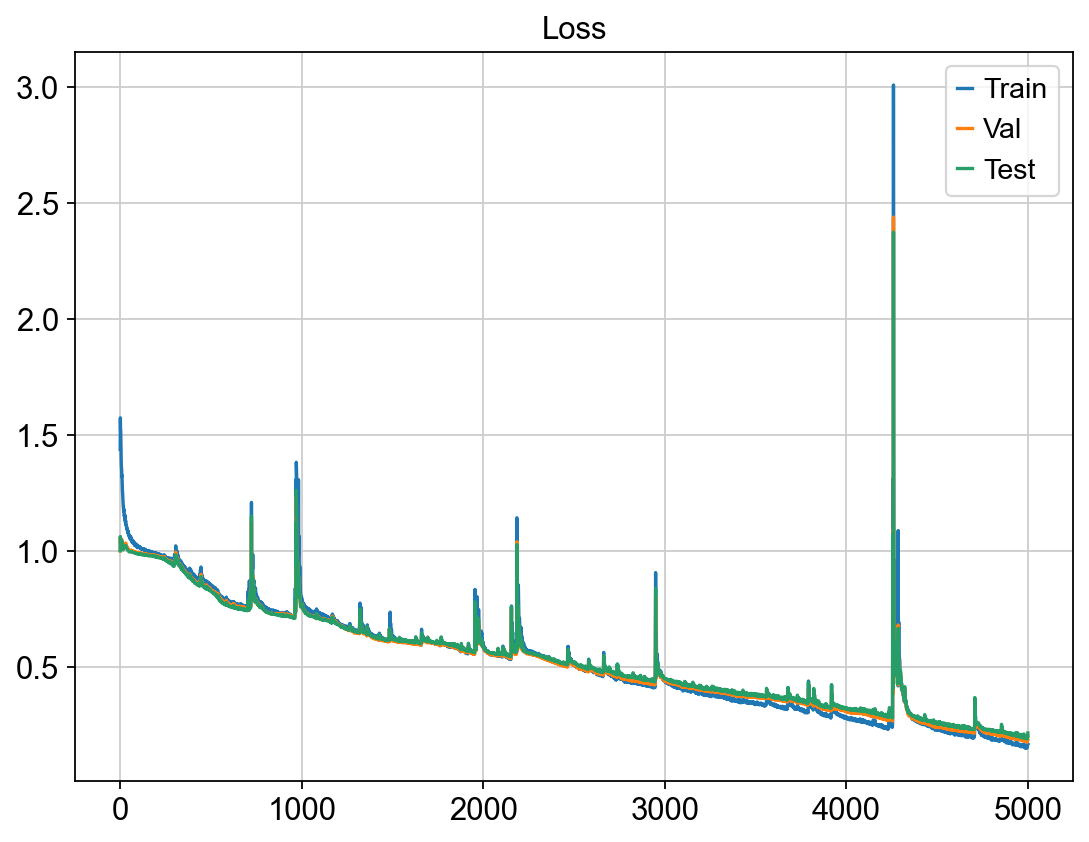

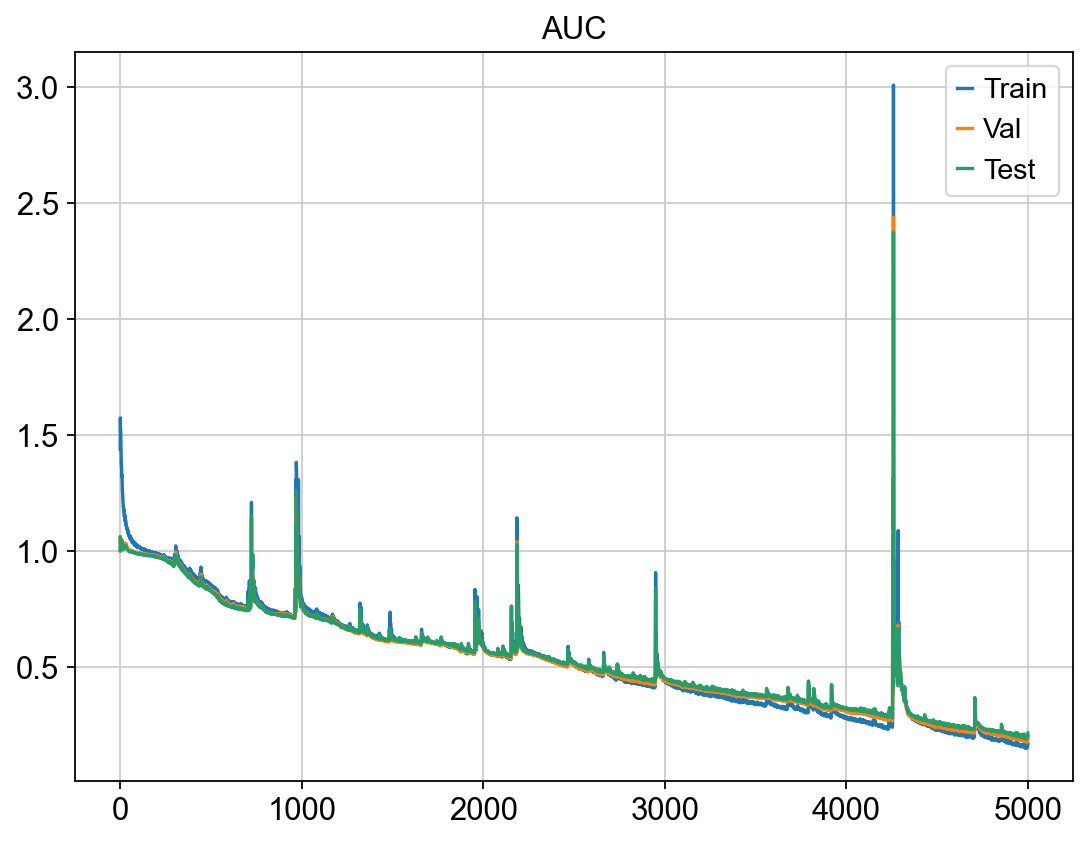

In [51]:
[train_GNN, val_GNN, test_GNN], [train_labels, val_labels, test_labels], cell_type_list, gene_list = \
    pipeline([train_data, val_data, test_data], args, d, cell_type_str)

Import the saved models and assignment matrix.

In [52]:
model_dir = f'{d}output/model_{cell_type_str}.pth'
model = torch.load(model_dir)
train_s_dir = f'{d}output/train_s_{cell_type_str}.npy'
train_s = torch.tensor(np.load(train_s_dir))

Compute the test score and AUC.

In [53]:
test_data_reduced = test_GNN.x.t() @ train_s
val_data_reduced = val_GNN.x.t() @ train_s
test_score, _, test_auc = test_model(model, test_data_reduced, test_labels)
val_score, _, val_auc = test_model(model, val_data_reduced, val_labels)

print(f'Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}')

Val AUC: 0.8750, Test AUC: 0.8615


Apply the Leiden algorithm to the reduced data for unsupervised clustering.

In [61]:
test_reduced = compute_leiden(test_data_reduced.detach().numpy(), test_data, n_neighbors=20, resolution=1)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


Plot the contingency matrix.

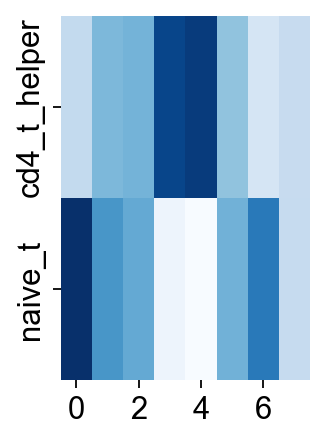

In [62]:
plt.figure(figsize=(2, 3), dpi=80)
plot_contingency(test_reduced, cell_type_list, cell_type_str, d)

Plot the confusion matrix.

<Figure size 480x320 with 0 Axes>

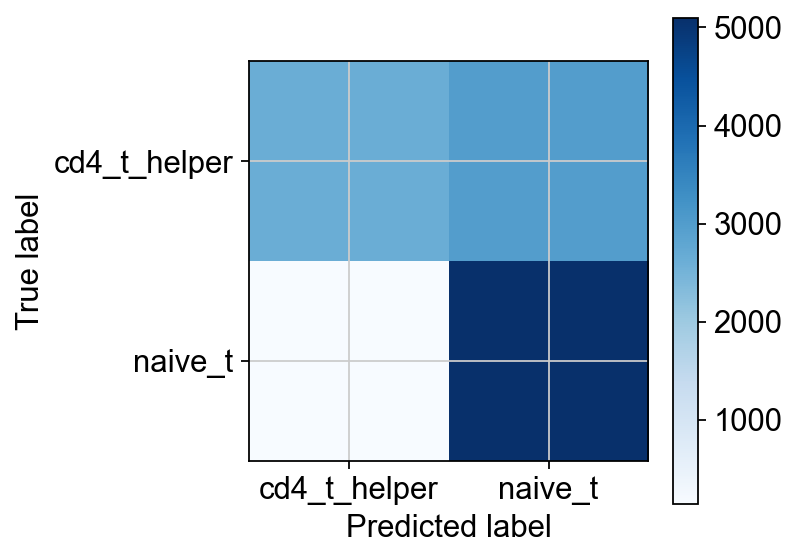

In [63]:
plt.figure(figsize=(6, 4), dpi=80)
plot_confusion(test_reduced, cell_type_str, d)

Plot the TSNE.

computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:29)


<Figure size 320x320 with 0 Axes>

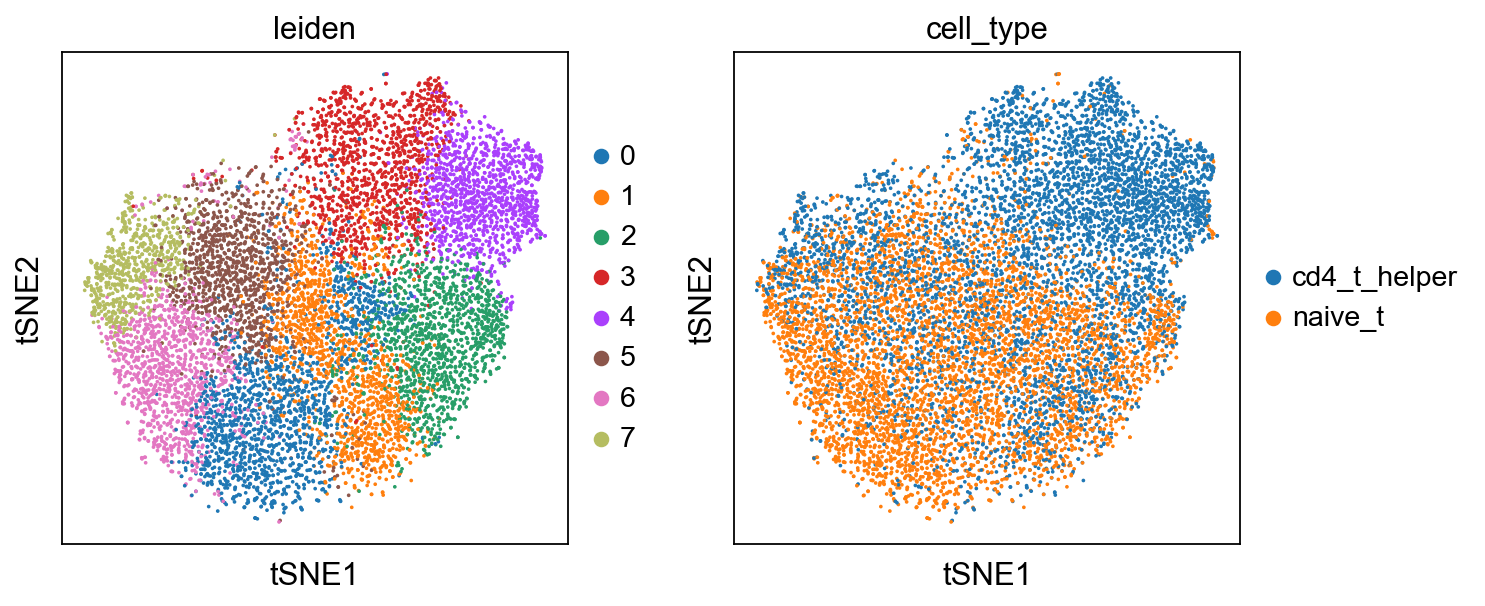

In [66]:
plt.figure()
sc.settings.set_figure_params(figsize=(4, 4), dpi=80)
sc.tl.tsne(test_reduced, n_pcs=0)
sc.pl.tsne(test_reduced, color=["leiden", "cell_type"], legend_loc="right margin", return_fig=True)
plt.savefig(d + "figures/tsne_" + cell_type_str + ".pdf")

Plot the heatmap of the assignment matrx.

<Figure size 240x240 with 0 Axes>

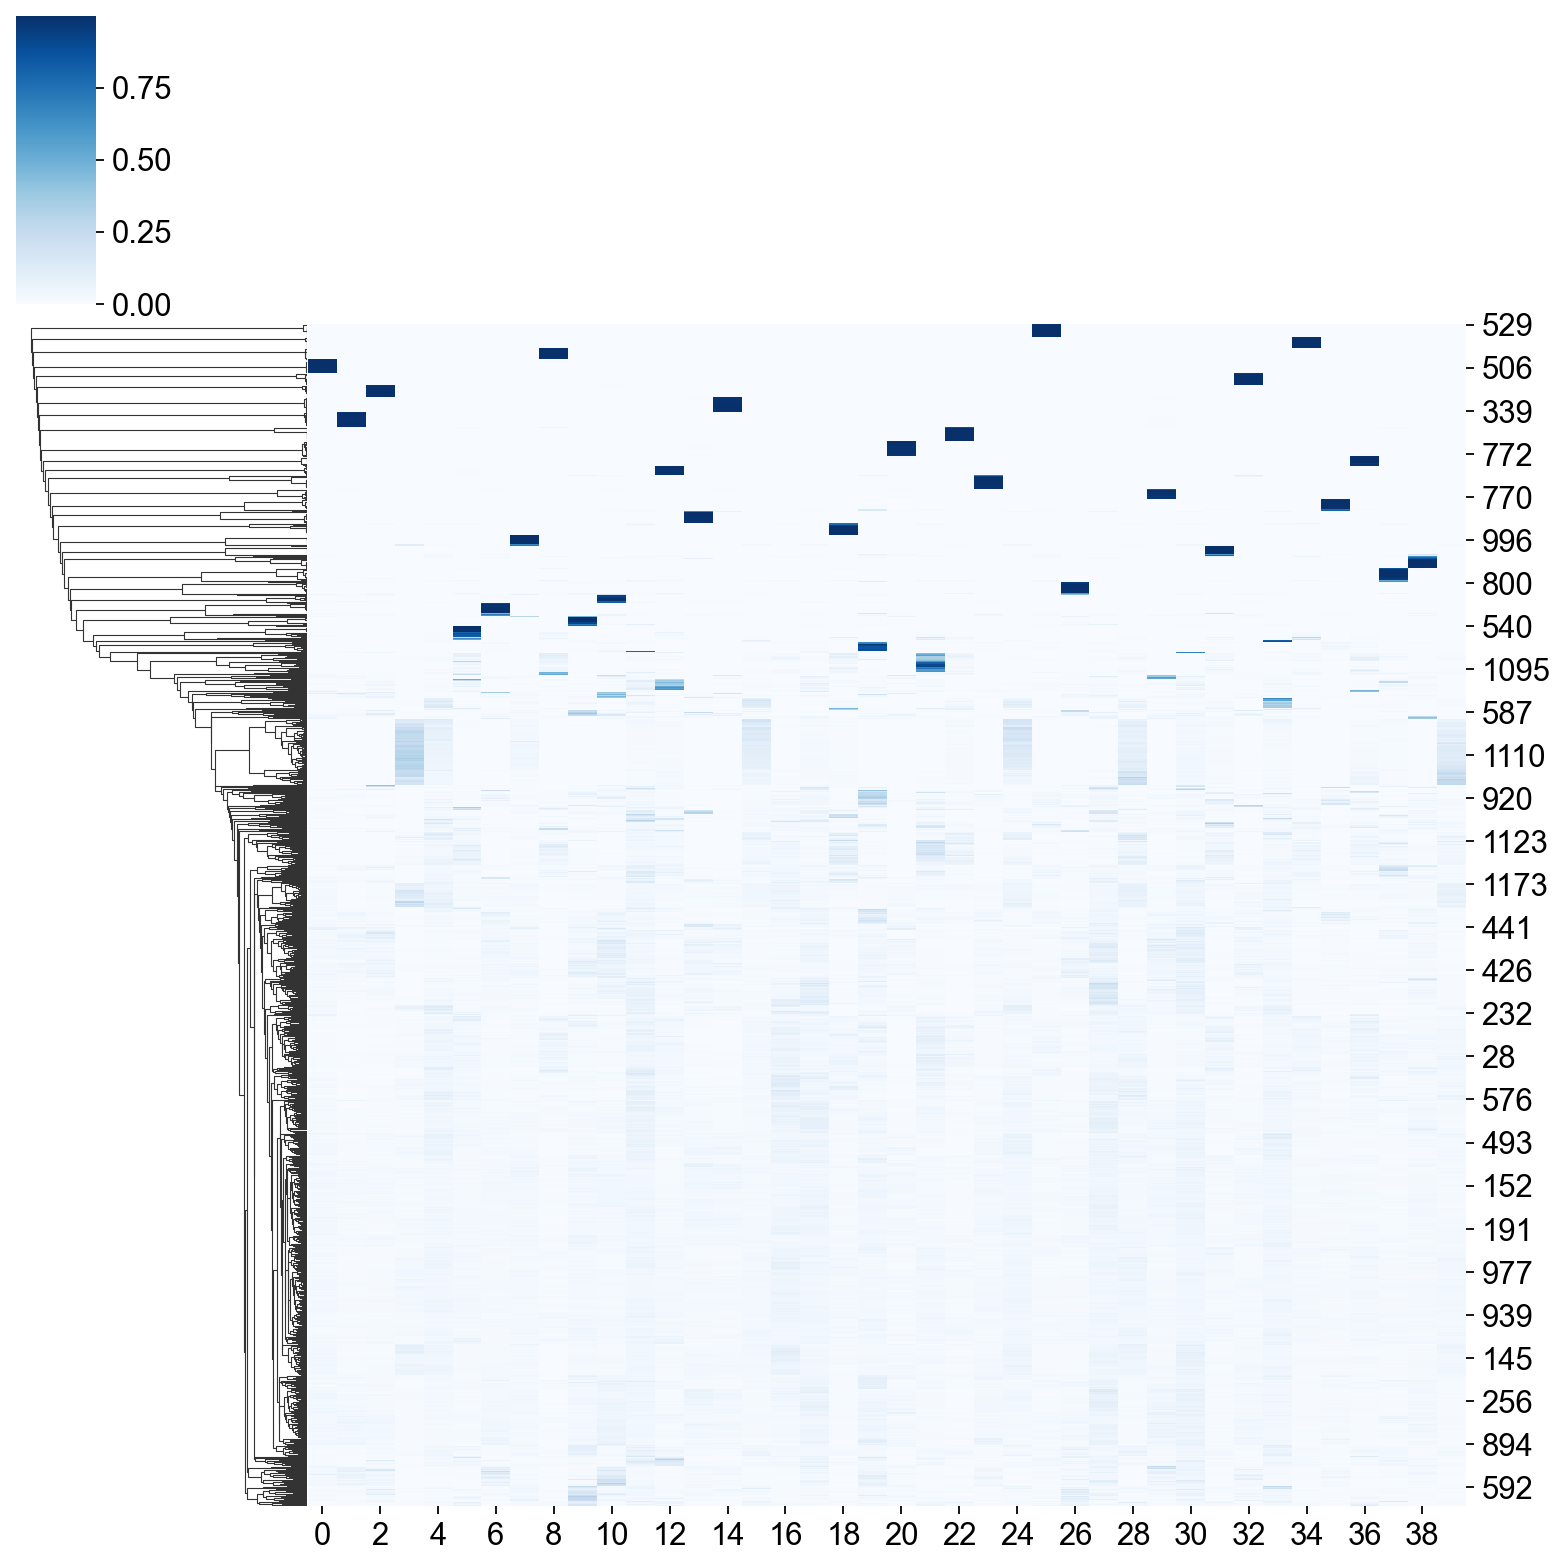

In [67]:
plt.figure(figsize=(3, 3), dpi=80)
plot_s(train_s, cell_type_str, d)

Save the names of genes for each component of the assignment matrix.

In [68]:
s2name(train_s, gene_list, cell_type_str, d)

In [74]:
pd.read_csv(f'{d}/output/name_s_{cell_type_str}.txt', sep='\t', header=None)

,0
0,"RP11-1399P15.1,TMBIM1,TAGAP,AP3M2,C9orf69,SLC3..."
1,"NBL1,CDC42EP3,AC017002.1,GTDC1,BTD,FRMD4B,PIGX..."
2,"CD84,GYG1,C5orf56,EEPD1,CHST7,SH2D1A,IL2RA,KLR..."
3,"RHOC,TIGIT,PERP,AMICA1,MBOAT7,C1orf162,LYRM4,A..."
4,"TNFRSF25,ELOVL1,CAPG,LTC4S,ADK,NCKAP1L,UBL3,AL..."
5,"LTB,GIMAP7,GIMAP4,KLF2,FXYD5,MT-ND2,MT-CO2,MT-..."
6,"SYTL1,RGS1,SLC52A2,ACYP1,SRR,MEI1,OXNAD1,LRRN3..."
7,"SH3BGRL3,MTHFD2,LYPLA1,TC2N,CRIP2,COTL1,HN1"
8,"S100A11,LIMS1,PASK,GRK6,RFK,GPR183,CTSH,CORO7"
9,DUSP1
